# Tutorial: LLM Experiments

![Status](https://img.shields.io/static/v1.svg?label=Status&message=Finished&color=green)

**Filled notebook:**
[![View filled on Github](https://img.shields.io/static/v1.svg?logo=github&label=Repo&message=View%20On%20Github&color=lightgrey)](https://github.com/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE-pytorch8-2025Fall.ipynb)
[![Open filled In Collab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lkk688/DeepDataMiningLearning/blob/master/docs/notebooks/CMPE-pytorch8-2025Fall.ipynb)       
**Author:** Kaikai Liu

## RNN Final-Token vs Per-Token

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

# ----- Example corpus -----
corpus = ["hello", "world", "pytorch", "hi"]

# ----- Build character vocabulary -----
chars = sorted(list(set("".join(corpus))))
stoi = {ch: i+1 for i, ch in enumerate(chars)}  # start at 1
stoi["<pad>"] = 0  # padding token
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)
print("Vocab:", stoi)

# ----- Encode/decode -----
def encode(s): return [stoi[c] for c in s]
def decode(indices): return "".join([itos[i] for i in indices])

Vocab: {'c': 1, 'd': 2, 'e': 3, 'h': 4, 'i': 5, 'l': 6, 'o': 7, 'p': 8, 'r': 9, 't': 10, 'w': 11, 'y': 12, '<pad>': 0}


In [ ]:
data = []
for word in corpus:
    enc = encode(word)
    for i in range(1, len(enc)):  # at least 1 char prefix
        x = enc[:i]
        y = enc[i]
        data.append((x, y))
print(f"Total samples: {len(data)}")
for x, y in data[:5]:
    print(decode(x), "→", decode([y]))

Total samples: 15
h → e
he → l
hel → l
hell → o
w → o


In [ ]:
data

[([4], 3),
 ([4, 3], 6),
 ([4, 3, 6], 6),
 ([4, 3, 6, 6], 7),
 ([11], 7),
 ([11, 7], 9),
 ([11, 7, 9], 6),
 ([11, 7, 9, 6], 2),
 ([8], 12),
 ([8, 12], 10),
 ([8, 12, 10], 7),
 ([8, 12, 10, 7], 9),
 ([8, 12, 10, 7, 9], 1),
 ([8, 12, 10, 7, 9, 1], 4),
 ([4], 5)]

In [ ]:
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn_char(batch):
    """
    Pads variable-length character sequences for RNN training.
    Each sample is (input_seq, target_char).

    Returns:
        x_padded: LongTensor [B, T]
        y_tensor: LongTensor [B]
        lengths:  LongTensor [B] (true sequence lengths)
    """
    # 1️⃣ Unzip batch into separate lists
    xs, ys = zip(*batch)

    # 2️⃣ Convert each input sequence to tensor
    x_tensors = [torch.tensor(x, dtype=torch.long) for x in xs]

    # 3️⃣ Compute true lengths before padding
    lengths = torch.tensor([len(x) for x in x_tensors], dtype=torch.long)

    # 4️⃣ Pad sequences with 0 to match longest sequence in batch
    x_padded = pad_sequence(x_tensors, batch_first=True, padding_value=0)

    # 5️⃣ Convert targets to a tensor
    y_tensor = torch.tensor(ys, dtype=torch.long)

    return x_padded, y_tensor, lengths

In [ ]:
x_padded, y_tensor, lengths = collate_fn_char(data)

In [ ]:
x_padded

tensor([[ 4,  0,  0,  0,  0,  0],
        [ 4,  3,  0,  0,  0,  0],
        [ 4,  3,  6,  0,  0,  0],
        [ 4,  3,  6,  6,  0,  0],
        [11,  0,  0,  0,  0,  0],
        [11,  7,  0,  0,  0,  0],
        [11,  7,  9,  0,  0,  0],
        [11,  7,  9,  6,  0,  0],
        [ 8,  0,  0,  0,  0,  0],
        [ 8, 12,  0,  0,  0,  0],
        [ 8, 12, 10,  0,  0,  0],
        [ 8, 12, 10,  7,  0,  0],
        [ 8, 12, 10,  7,  9,  0],
        [ 8, 12, 10,  7,  9,  1],
        [ 4,  0,  0,  0,  0,  0]])

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        emb = self.embed(x)            # [B, T, E]
        out, _ = self.rnn(emb)         # [B, T, H]
        logits = self.fc(out)          # [B, T, V]
        return logits

Case 1 — Last-token loss training

In [ ]:
def train_last_token(model, data, vocab_size, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        # Collate batch
        x_padded, y_tensor, lengths = collate_fn_char(data)

        # Forward
        logits = model(x_padded)  # [B, T, V]
        # Take only last output for each sequence
        last_indices = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, vocab_size)
        last_logits = logits.gather(1, last_indices).squeeze(1)  # [B, V]

        loss = criterion(last_logits, y_tensor)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"[Last-token] Epoch {epoch+1}, Loss: {loss.item():.4f}")

Case 2 — Per-token loss training

In [ ]:
# Create per-token training data
seqs = [torch.tensor(encode(word), dtype=torch.long) for word in corpus]
x_seqs = [seq[:-1] for seq in seqs if len(seq) > 1]
y_seqs = [seq[1:] for seq in seqs if len(seq) > 1]
data_token = list(zip(x_seqs, y_seqs))

In [ ]:
def collate_fn_seq(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=0)
    y_padded = pad_sequence(ys, batch_first=True, padding_value=0)
    return x_padded, y_padded

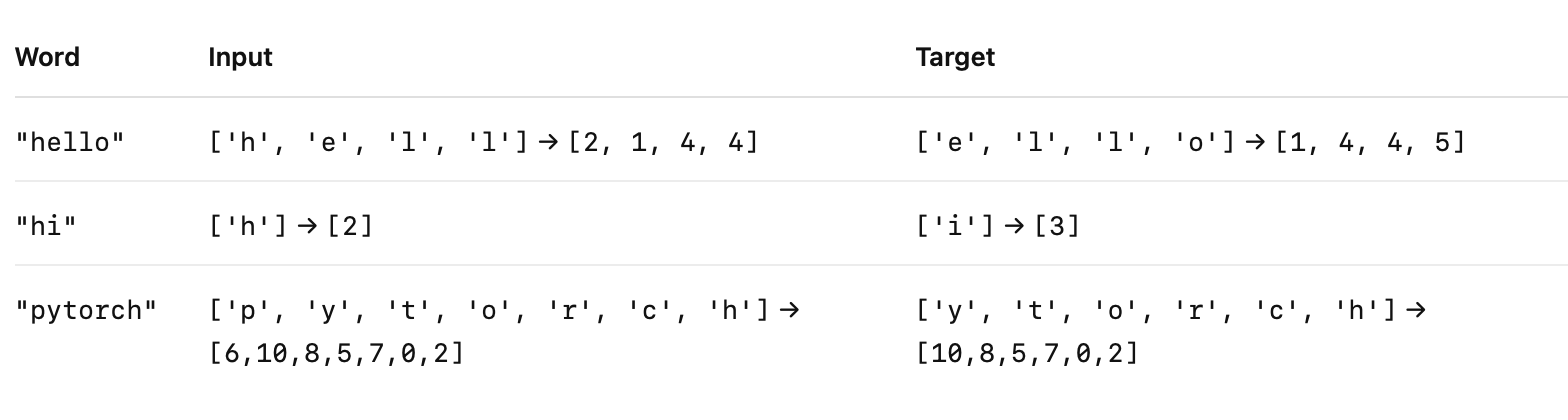

In [ ]:
def train_per_token(model, data_token, vocab_size, epochs=200):
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss(ignore_index=0)  # ignore padding

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()

        x_padded, y_padded = collate_fn_seq(data_token)
        logits = model(x_padded)  # [B, T, V]

        # Flatten for cross-entropy
        loss = criterion(logits.reshape(-1, vocab_size), y_padded.reshape(-1))
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 50 == 0:
            print(f"[Per-token] Epoch {epoch+1}, Loss: {loss.item():.4f}")

In [ ]:
embed_size, hidden_size = 32, 64

# ----- Last-token model -----
model_last = CharRNN(vocab_size, embed_size, hidden_size)
train_last_token(model_last, data, vocab_size)

# ----- Per-token model -----
model_token = CharRNN(vocab_size, embed_size, hidden_size)
train_per_token(model_token, data_token, vocab_size)

[Last-token] Epoch 50, Loss: 0.0930
[Last-token] Epoch 100, Loss: 0.0928
[Last-token] Epoch 150, Loss: 0.0927
[Last-token] Epoch 200, Loss: 0.0926
[Per-token] Epoch 50, Loss: 0.0929
[Per-token] Epoch 100, Loss: 0.0927
[Per-token] Epoch 150, Loss: 0.0927
[Per-token] Epoch 200, Loss: 0.0926


In [ ]:
with torch.no_grad():
    logits = model_last(x_padded)
    last_indices = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, vocab_size)
    preds = logits.gather(1, last_indices).squeeze(1).argmax(dim=1)
    acc = (preds == y_tensor).float().mean().item()
    print("Accuracy:", acc)

Accuracy: 0.9333333373069763


In [ ]:
with torch.no_grad():
    logits = model_token(x_padded)
    last_indices = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, vocab_size)
    preds = logits.gather(1, last_indices).squeeze(1).argmax(dim=1)
    acc = (preds == y_tensor).float().mean().item()
    print("Accuracy:", acc)

Accuracy: 0.9333333373069763


## RNN Word Sample

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt
import random, string
torch.manual_seed(42)

In [ ]:
# Sample English-like words
corpus = [
    "hello", "world", "python", "teacher", "force", "final", "token",
    "sequence", "neural", "network", "training", "torch", "model"
]
# Expand dataset slightly by random shuffling
corpus = corpus * 50  # 650 words total

# Build vocabulary (lowercase letters + space + <pad>)
chars = list(string.ascii_lowercase + " ") + ["<eos>", "<pad>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
eos_idx = stoi["<eos>"]
pad_idx = stoi["<pad>"]
vocab_size = len(stoi)

#Append <eos> to every training word:
def encode(word):
    return [stoi[c] for c in word.lower() if c in stoi] + [eos_idx]

def decode(indices):
    return "".join([itos[i] for i in indices if i in itos])

In [ ]:
vocab_size

29

In [ ]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 ' ': 26,
 '<eos>': 27,
 '<pad>': 28}

In [ ]:
itos

{0: 'a',
 1: 'b',
 2: 'c',
 3: 'd',
 4: 'e',
 5: 'f',
 6: 'g',
 7: 'h',
 8: 'i',
 9: 'j',
 10: 'k',
 11: 'l',
 12: 'm',
 13: 'n',
 14: 'o',
 15: 'p',
 16: 'q',
 17: 'r',
 18: 's',
 19: 't',
 20: 'u',
 21: 'v',
 22: 'w',
 23: 'x',
 24: 'y',
 25: 'z',
 26: ' ',
 27: '<eos>',
 28: '<pad>'}

Dataset supports both final-token and per-token modes.

In [ ]:
class CharDataset(Dataset):
    def __init__(self, corpus, mode="final-token"):
        self.data = []
        self.mode = mode

        for word in corpus:
            seq = encode(word)
            if len(seq) < 2:
                continue

            if mode == "final-token":
                # Each word → predict next char after full prefix
                # Input: all chars except last, Target: last char
                self.data.append((torch.tensor(seq[:-1]), torch.tensor(seq[-1])))
            elif mode == "per-token":
                # Predict each next char step by step
                x, y = seq[:-1], seq[1:]
                self.data.append((torch.tensor(x), torch.tensor(y)))
            else:
                raise ValueError("Invalid mode")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [ ]:
def collate_final(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=pad_idx)
    y_tensor = torch.stack(ys)
    lengths = torch.tensor([len(x) for x in xs])
    return x_padded, y_tensor, lengths

def collate_per_token(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=pad_idx)
    y_padded = pad_sequence(ys, batch_first=True, padding_value=pad_idx)
    return x_padded, y_padded

In [ ]:
class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)

    def forward(self, x, hidden=None):
        emb = self.embed(x)
        out, hidden = self.lstm(emb, hidden)
        logits = self.fc(out)
        return logits, hidden

In [ ]:
def train_model(model, dataloader, mode="final-token", epochs=10, lr=0.001, clip=1.0):
    """
    Efficient training loop for LSTM with:
    - Final-token loss
    - Per-token loss (teacher-forced, vectorized)
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    losses = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        num_batches = 0

        for batch in tqdm(dataloader, desc=f"[{mode}] Epoch {epoch+1}/{epochs}", ncols=100):
            optimizer.zero_grad()

            if mode == "final-token":
                x, y, lengths = batch
                logits, _ = model(x)             # [B, T, V]
                # get last output for each sequence
                last_outputs = torch.stack(
                    [logits[i, l-1, :] for i, l in enumerate(lengths)], dim=0
                )
                loss = criterion(last_outputs, y)

            elif mode == "per-token":
                x, y = batch                     # [B, T]
                logits, _ = model(x)             # [B, T, V]
                # reshape for CE loss
                loss = criterion(
                    logits.reshape(-1, logits.size(-1)),
                    y.reshape(-1)
                )
            else:
                raise ValueError("mode must be 'final-token' or 'per-token'")

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        print(f"✅ Epoch {epoch+1}: avg loss = {avg_loss:.4f}")

    return losses

In [ ]:
def evaluate_model(model, dataloader, mode="final-token"):
    """
    Evaluate model on test/validation data.

    Args:
        model: trained LSTM or Transformer
        dataloader: DataLoader for test/val dataset
        mode: 'final-token' or 'per-token'

    Returns:
        avg_loss: average loss over dataset
        accuracy: average accuracy
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    total_loss, total_correct, total_count = 0, 0, 0

    with torch.no_grad():
        for batch in dataloader:
            if mode == "final-token":
                x, y, lengths = batch
                logits, _ = model(x)
                # pick last time step output
                last_outputs = torch.stack(
                    [logits[i, l-1, :] for i, l in enumerate(lengths)], dim=0
                )
                loss = criterion(last_outputs, y)
                preds = last_outputs.argmax(1)
                total_correct += (preds == y).sum().item()
                total_count += y.size(0)

            elif mode == "per-token":
                x, y = batch
                logits, _ = model(x)
                loss = criterion(
                    logits.reshape(-1, logits.size(-1)),
                    y.reshape(-1)
                )
                preds = logits.argmax(2)
                mask = (y != pad_idx)
                total_correct += ((preds == y) * mask).sum().item()
                total_count += mask.sum().item()

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    accuracy = total_correct / total_count if total_count > 0 else 0
    print(f"🔍 Evaluation ({mode}) — Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%")
    return avg_loss, accuracy

In [ ]:
def generate_word(model, start="he", max_len=10):
    """
    Autoregressively generate next characters from a trained model.

    Args:
        model: trained LSTM
        start: prefix string
        max_len: maximum length to generate
    """
    model.eval()
    input_seq = torch.tensor([[stoi[c] for c in start]], dtype=torch.long)
    hidden = None
    output = start

    with torch.no_grad():
        for _ in range(max_len):
            logits, hidden = model(input_seq)
            next_token = logits[:, -1, :].argmax(1).item()
            next_char = itos[next_token]
            #if next_char == " ":
            if next_char == "<eos>":
                break
            output += next_char
            input_seq = torch.cat([input_seq, torch.tensor([[next_token]])], dim=1)

    return output

In [ ]:
import torch.nn.functional as F

def generate_word_sample(model, start="he", max_len=20, temperature=0.9, top_k=5):
    model.eval()
    input_seq = torch.tensor([[stoi[c] for c in start]], dtype=torch.long)
    hidden = None
    output = start

    with torch.no_grad():
        for _ in range(max_len):
            logits, hidden = model(input_seq)
            next_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_logits, dim=-1)

            # restrict to top-k
            top_probs, top_idx = probs.topk(top_k)
            top_probs = top_probs / top_probs.sum()
            next_token = top_idx[0, torch.multinomial(top_probs, 1)].item()

            next_char = itos[next_token]
            if next_char == "<eos>":
                break
            output += next_char
            input_seq = torch.cat([input_seq, torch.tensor([[next_token]])], dim=1)
    return output

In [ ]:
from torch.utils.data import random_split

# split 80% train / 20% test
train_size = int(0.8 * len(corpus))
test_size = len(corpus) - train_size
train_corpus, test_corpus = random_split(corpus, [train_size, test_size])

In [ ]:
batch_size = 64

# Final-token mode
train_final = CharDataset(train_corpus, mode="final-token")
test_final = CharDataset(test_corpus, mode="final-token")
dl_train_final = DataLoader(train_final, batch_size=batch_size, shuffle=True, collate_fn=collate_final)
dl_test_final = DataLoader(test_final, batch_size=batch_size, shuffle=False, collate_fn=collate_final)

# Per-token mode (teacher-forced)
train_token = CharDataset(train_corpus, mode="per-token")
test_token = CharDataset(test_corpus, mode="per-token")
dl_train_token = DataLoader(train_token, batch_size=batch_size, shuffle=True, collate_fn=collate_per_token)
dl_test_token = DataLoader(test_token, batch_size=batch_size, shuffle=False, collate_fn=collate_per_token)

In [ ]:
model_final = CharLSTM(vocab_size)
model_token = CharLSTM(vocab_size)

loss_final = train_model(model_final, dl_train_final, mode="final-token", epochs=15)
loss_token = train_model(model_token, dl_train_token, mode="per-token", epochs=15)

[final-token] Epoch 1/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 161.47it/s]


✅ Epoch 1: avg loss = 2.9726


[final-token] Epoch 2/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 304.94it/s]


✅ Epoch 2: avg loss = 1.4995


[final-token] Epoch 3/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 326.20it/s]


✅ Epoch 3: avg loss = 0.1079


[final-token] Epoch 4/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 325.22it/s]


✅ Epoch 4: avg loss = 0.0026


[final-token] Epoch 5/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 326.55it/s]


✅ Epoch 5: avg loss = 0.0005


[final-token] Epoch 6/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 330.01it/s]


✅ Epoch 6: avg loss = 0.0003


[final-token] Epoch 7/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 334.93it/s]


✅ Epoch 7: avg loss = 0.0002


[final-token] Epoch 8/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 411.57it/s]


✅ Epoch 8: avg loss = 0.0002


[final-token] Epoch 9/15: 100%|██████████████████████████████████████| 9/9 [00:00<00:00, 413.89it/s]


✅ Epoch 9: avg loss = 0.0002


[final-token] Epoch 10/15: 100%|█████████████████████████████████████| 9/9 [00:00<00:00, 417.59it/s]


✅ Epoch 10: avg loss = 0.0002


[final-token] Epoch 11/15: 100%|█████████████████████████████████████| 9/9 [00:00<00:00, 388.55it/s]


✅ Epoch 11: avg loss = 0.0002


[final-token] Epoch 12/15: 100%|█████████████████████████████████████| 9/9 [00:00<00:00, 416.39it/s]


✅ Epoch 12: avg loss = 0.0002


[final-token] Epoch 13/15: 100%|█████████████████████████████████████| 9/9 [00:00<00:00, 410.63it/s]


✅ Epoch 13: avg loss = 0.0002


[final-token] Epoch 14/15: 100%|█████████████████████████████████████| 9/9 [00:00<00:00, 417.06it/s]


✅ Epoch 14: avg loss = 0.0002


[final-token] Epoch 15/15: 100%|█████████████████████████████████████| 9/9 [00:00<00:00, 416.03it/s]


✅ Epoch 15: avg loss = 0.0002


[per-token] Epoch 1/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 653.70it/s]


✅ Epoch 1: avg loss = 3.2435


[per-token] Epoch 2/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 640.80it/s]


✅ Epoch 2: avg loss = 2.8637


[per-token] Epoch 3/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 408.56it/s]


✅ Epoch 3: avg loss = 2.4252


[per-token] Epoch 4/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 554.08it/s]


✅ Epoch 4: avg loss = 2.1022


[per-token] Epoch 5/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 535.17it/s]


✅ Epoch 5: avg loss = 1.7652


[per-token] Epoch 6/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 556.54it/s]


✅ Epoch 6: avg loss = 1.4580


[per-token] Epoch 7/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 487.36it/s]


✅ Epoch 7: avg loss = 1.1674


[per-token] Epoch 8/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 558.17it/s]


✅ Epoch 8: avg loss = 0.9248


[per-token] Epoch 9/15: 100%|████████████████████████████████████████| 9/9 [00:00<00:00, 443.75it/s]


✅ Epoch 9: avg loss = 0.7104


[per-token] Epoch 10/15: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 372.90it/s]


✅ Epoch 10: avg loss = 0.5542


[per-token] Epoch 11/15: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 557.28it/s]


✅ Epoch 11: avg loss = 0.4310


[per-token] Epoch 12/15: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 536.31it/s]


✅ Epoch 12: avg loss = 0.3477


[per-token] Epoch 13/15: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 567.62it/s]


✅ Epoch 13: avg loss = 0.2887


[per-token] Epoch 14/15: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 513.57it/s]


✅ Epoch 14: avg loss = 0.2423


[per-token] Epoch 15/15: 100%|███████████████████████████████████████| 9/9 [00:00<00:00, 566.41it/s]

✅ Epoch 15: avg loss = 0.2168


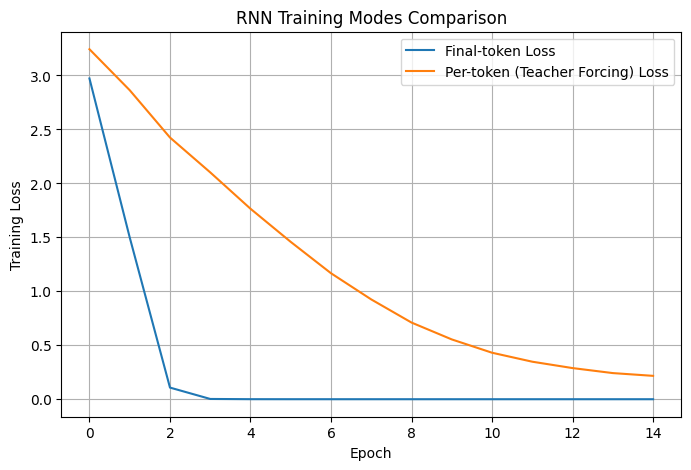

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(loss_final, label="Final-token Loss")
plt.plot(loss_token, label="Per-token (Teacher Forcing) Loss")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("RNN Training Modes Comparison")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
evaluate_model(model_final, dl_test_final, mode="final-token")
evaluate_model(model_token, dl_test_token, mode="per-token")

🔍 Evaluation (final-token) — Loss: 0.0002, Accuracy: 100.00%
🔍 Evaluation (per-token) — Loss: 0.2158, Accuracy: 92.81%


(0.21578919887542725, 0.9281129653401797)

In [ ]:
x,y=test_final[0]

In [ ]:
x

tensor([18,  4, 16, 20,  4, 13,  2,  4])

In [ ]:
y

tensor(27)

In [ ]:
corpus

['hello',
 'world',
 'python',
 'teacher',
 'force',
 'final',
 'token',
 'sequence',
 'neural',
 'network',
 'training',
 'torch',
 'model',
 'hello',
 'world',
 'python',
 'teacher',
 'force',
 'final',
 'token',
 'sequence',
 'neural',
 'network',
 'training',
 'torch',
 'model',
 'hello',
 'world',
 'python',
 'teacher',
 'force',
 'final',
 'token',
 'sequence',
 'neural',
 'network',
 'training',
 'torch',
 'model',
 'hello',
 'world',
 'python',
 'teacher',
 'force',
 'final',
 'token',
 'sequence',
 'neural',
 'network',
 'training',
 'torch',
 'model',
 'hello',
 'world',
 'python',
 'teacher',
 'force',
 'final',
 'token',
 'sequence',
 'neural',
 'network',
 'training',
 'torch',
 'model',
 'hello',
 'world',
 'python',
 'teacher',
 'force',
 'final',
 'token',
 'sequence',
 'neural',
 'network',
 'training',
 'torch',
 'model',
 'hello',
 'world',
 'python',
 'teacher',
 'force',
 'final',
 'token',
 'sequence',
 'neural',
 'network',
 'training',
 'torch',
 'model',
 'hell

In [ ]:
print("\nFinal-token model generations:")
for prefix in ["he", "ne", "tr", "py", "networ", "mode", "toke"]:
    print(" ", prefix, "→", generate_word(model_final, prefix))

print("\nPer-token (teacher-forcing) model generations:")
for prefix in ["he", "ne", "tr", "py", "networ", "mode", "toke"]:
    print(" ", prefix, "→", generate_word(model_token, prefix))


Final-token model generations:
  he → he
  ne → ne
  tr → tr
  py → pyg
  networ → networ
  mode → mode
  toke → toke

Per-token (teacher-forcing) model generations:
  he → hello
  ne → network
  tr → training
  py → python
  networ → network
  mode → model
  toke → token


In [ ]:
generate_word(model_final, "forc")

'forc'

In [ ]:
print("\nFinal-token model generations:")
for prefix in ["he", "ne", "tr", "py", "networ", "mode", "toke"]:
    print(" ", prefix, "→", generate_word_sample(model_final, prefix))

print("\nPer-token (teacher-forcing) model generations:")
for prefix in ["he", "ne", "tr", "py", "networ", "mode", "toke"]:
    print(" ", prefix, "→", generate_word_sample(model_token, prefix))


Final-token model generations:
  he → he
  ne → ne
  tr → tr
  py → pyeg
  networ → networ
  mode → mode
  toke → toke

Per-token (teacher-forcing) model generations:
  he → hello
  ne → neueural
  tr → training
  py → python
  networ → network
  mode → model
  toke → token


## Transformer Encoder

In [ ]:
import torch, torch.nn as nn

B, T, D = 4, 16, 512
x = torch.randn(B, T, D)

layer = nn.TransformerEncoderLayer(d_model=D, nhead=8, batch_first=True)
encoder = nn.TransformerEncoder(layer, num_layers=6)

# Optional: causal mask if you want decoder-like behavior
causal_mask = torch.triu(torch.full((T, T), float('-inf')), diagonal=1)

# Optional: padding mask
pad_mask = torch.zeros(B, T, dtype=torch.bool)  # no padding here

y = encoder(x, mask=causal_mask, src_key_padding_mask=pad_mask)  # (B, T, D)

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched src_key_padding_mask and mask is deprecated. Use same type for both instead.
  warnings.warn(


In [ ]:
y.shape

torch.Size([4, 16, 512])

## English Word

In [ ]:
import nltk
nltk.download('words')
from nltk.corpus import words

corpus = words.words()

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
len(corpus)

236736

In [ ]:
corpus[1:10]

['a', 'aa', 'aal', 'aalii', 'aam', 'Aani', 'aardvark', 'aardwolf', 'Aaron']

In [ ]:
import string

chars = list(string.ascii_lowercase) + ["<pad>"]
stoi = {ch: i for i, ch in enumerate(chars)}   # map char→index
itos = {i: ch for ch, i in stoi.items()}
vocab_size = len(stoi)
print("Vocab:", stoi)

Vocab: {'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4, 'f': 5, 'g': 6, 'h': 7, 'i': 8, 'j': 9, 'k': 10, 'l': 11, 'm': 12, 'n': 13, 'o': 14, 'p': 15, 'q': 16, 'r': 17, 's': 18, 't': 19, 'u': 20, 'v': 21, 'w': 22, 'x': 23, 'y': 24, 'z': 25, '<pad>': 26}


In [ ]:
#For final-token loss (prefix → next char)
import torch
data_final = []
for word in corpus:
    w = word.lower()
    if len(w) < 2:
        continue
    #seq = [stoi[c] for c in w]
    seq = [stoi[c] for c in w if c in stoi]
    for i in range(1, len(seq)):
        data_final.append((torch.tensor(seq[:i]), torch.tensor(seq[i])))

In [ ]:
data_final[0:10]

[(tensor([0]), tensor(0)),
 (tensor([0]), tensor(0)),
 (tensor([0, 0]), tensor(11)),
 (tensor([0]), tensor(0)),
 (tensor([0, 0]), tensor(11)),
 (tensor([ 0,  0, 11]), tensor(8)),
 (tensor([ 0,  0, 11,  8]), tensor(8)),
 (tensor([0]), tensor(0)),
 (tensor([0, 0]), tensor(12)),
 (tensor([0]), tensor(0))]

In [ ]:
len(data_token)

4

In [ ]:
#For per-token loss (sequence → next sequence)
#seqs = [torch.tensor([stoi[c] for c in w]) for w in corpus if len(w) > 1]
seqs = [torch.tensor([stoi[c] for c in w.lower() if c in stoi]) for w in corpus if len(w) > 1]
x_seqs = [s[:-1] for s in seqs]
y_seqs = [s[1:] for s in seqs]
data_token = list(zip(x_seqs, y_seqs))

In [ ]:
data_token[0:10]

[(tensor([0]), tensor([0])),
 (tensor([0, 0]), tensor([ 0, 11])),
 (tensor([ 0,  0, 11,  8]), tensor([ 0, 11,  8,  8])),
 (tensor([0, 0]), tensor([ 0, 12])),
 (tensor([ 0,  0, 13]), tensor([ 0, 13,  8])),
 (tensor([ 0,  0, 17,  3, 21,  0, 17]), tensor([ 0, 17,  3, 21,  0, 17, 10])),
 (tensor([ 0,  0, 17,  3, 22, 14, 11]), tensor([ 0, 17,  3, 22, 14, 11,  5])),
 (tensor([ 0,  0, 17, 14]), tensor([ 0, 17, 14, 13])),
 (tensor([ 0,  0, 17, 14, 13,  8]), tensor([ 0, 17, 14, 13,  8,  2])),
 (tensor([ 0,  0, 17, 14, 13,  8,  2,  0]),
  tensor([ 0, 17, 14, 13,  8,  2,  0, 11]))]

In [ ]:
len(data_token)

236682

In [ ]:
from torch.nn.utils.rnn import pad_sequence

def collate_final(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=stoi["<pad>"])
    y_tensor = torch.stack(ys)
    lengths = torch.tensor([len(x) for x in xs])
    return x_padded, y_tensor, lengths

def collate_seq(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=stoi["<pad>"])
    y_padded = pad_sequence(ys, batch_first=True, padding_value=stoi["<pad>"])
    return x_padded, y_padded

In [ ]:
import torch.nn as nn

class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=64, hidden_size=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.RNN(embed_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x):
        emb = self.embed(x)
        out, _ = self.rnn(emb)
        return self.fc(out)

In [ ]:
class CharTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size=64, nhead=4, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        encoder_layer = nn.TransformerEncoderLayer(embed_size, nhead, 128)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_size, vocab_size)

    def forward(self, x):
        emb = self.embed(x).permute(1, 0, 2)  # [T,B,E]
        out = self.encoder(emb).permute(1, 0, 2)
        return self.fc(out)

In [ ]:
from tqdm import tqdm
import random
import torch

def train_final(model, data, optimizer, criterion, epochs=5, batch_size=128, label=""):
    """
    Train a next-character prediction model using the "final-token" loss strategy.
    Only the final character in each sequence is used for loss computation.

    Args:
        model: PyTorch model (e.g., RNN or Transformer)
        data: list of (input_seq_tensor, target_char_tensor) pairs
        optimizer: PyTorch optimizer (e.g., Adam)
        criterion: loss function (e.g., nn.CrossEntropyLoss)
        epochs: number of full passes through the dataset
        batch_size: mini-batch size
        label: optional label to identify the model in logs

    Returns:
        losses: list of average loss values per epoch
    """
    model.train()                        # enable training mode (activates dropout, etc.)
    losses = []

    for epoch in range(epochs):
        # Shuffle data at each epoch for better stochastic training
        random.shuffle(data)
        total_loss = 0.0

        # Initialize tqdm progress bar for this epoch
        pbar = tqdm(range(0, len(data), batch_size), desc=f"[{label}] Epoch {epoch+1}/{epochs}", ncols=100)

        # Mini-batch training loop
        for i in pbar:
            batch = data[i:i + batch_size]

            # Collate function pads variable-length sequences to [B, T]
            x_padded, y_tensor, lengths = collate_final(batch)

            # Reset gradients from the previous batch
            optimizer.zero_grad()

            # Forward pass → compute logits [B, T, V]
            logits = model(x_padded)
            B, T, V = logits.shape

            # Select only the *last valid* token output for each sequence
            # Example: if a word has length 4, use output at index 3
            last_idx = (lengths - 1).unsqueeze(1).unsqueeze(2).expand(-1, 1, V)
            last_logits = logits.gather(1, last_idx).squeeze(1)  # [B, V]

            # Compute loss comparing predicted char vs. true next char
            loss = criterion(last_logits, y_tensor)

            # Backpropagation
            loss.backward()

            # Gradient descent step
            optimizer.step()

            # Accumulate total loss for epoch
            total_loss += loss.item() * len(batch)

            # Update progress bar display
            pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        # Compute average loss for this epoch
        avg_loss = total_loss / len(data)
        losses.append(avg_loss)

        # Print epoch summary
        print(f"[{label}] Epoch {epoch+1}/{epochs} — Avg Loss: {avg_loss:.4f}")

    return losses


def train_token(model, data, optimizer, criterion, epochs=5, batch_size=128, label=""):
    """
    Train a next-character prediction model using the "per-token" loss strategy.
    Each token in the input sequence contributes to the loss (dense supervision).

    Args:
        model: PyTorch model (e.g., RNN or Transformer)
        data: list of (input_seq_tensor, target_seq_tensor) pairs
        optimizer: PyTorch optimizer (e.g., Adam)
        criterion: loss function (e.g., nn.CrossEntropyLoss(ignore_index=pad_idx))
        epochs: number of epochs
        batch_size: mini-batch size
        label: optional label for progress tracking

    Returns:
        losses: list of average loss values per epoch
    """
    model.train()
    losses = []

    for epoch in range(epochs):
        random.shuffle(data)
        total_loss = 0.0

        # tqdm progress bar to track batch progress
        pbar = tqdm(range(0, len(data), batch_size), desc=f"[{label}] Epoch {epoch+1}/{epochs}", ncols=100)

        for i in pbar:
            batch = data[i:i + batch_size]

            # Collate to pad inputs and targets to [B, T]
            x_padded, y_padded = collate_seq(batch)

            optimizer.zero_grad()

            # Forward pass → model predicts logits for each position
            logits = model(x_padded)        # [B, T, V]

            # Flatten for loss computation (ignore padding tokens)
            loss = criterion(logits.view(-1, logits.size(-1)), y_padded.view(-1))

            # Backpropagation
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * len(batch)
            pbar.set_postfix({"batch_loss": f"{loss.item():.4f}"})

        avg_loss = total_loss / len(data)
        losses.append(avg_loss)
        print(f"[{label}] Epoch {epoch+1}/{epochs} — Avg Loss: {avg_loss:.4f}")

    return losses

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=stoi["<pad>"])

# ----- RNN Final-token -----
rnn_final = CharRNN(vocab_size)
opt_rnn_final = optim.Adam(rnn_final.parameters(), lr=0.001)
loss_rnn_final = train_final(rnn_final, data_final, opt_rnn_final, criterion, epochs=5, label="RNN Final-token")

# ----- RNN Per-token -----
rnn_token = CharRNN(vocab_size)
opt_rnn_token = optim.Adam(rnn_token.parameters(), lr=0.001)
loss_rnn_token = train_token(rnn_token, data_token, opt_rnn_token, criterion, epochs=5, label="RNN Per-token")

# ----- Transformer Final-token -----
trans_final = CharTransformer(vocab_size)
opt_trans_final = optim.Adam(trans_final.parameters(), lr=0.001)
loss_trans_final = train_final(trans_final, data_final, opt_trans_final, criterion, epochs=5, label="Transformer Final-token")

# ----- Transformer Per-token -----
trans_token = CharTransformer(vocab_size)
opt_trans_token = optim.Adam(trans_token.parameters(), lr=0.001)
loss_trans_token = train_token(trans_token, data_token, opt_trans_token, criterion, epochs=5, label="Transformer Per-token")

[RNN Final-token] Epoch 1/5: 100%|████████| 15820/15820 [00:59<00:00, 263.83it/s, batch_loss=1.8726]


[RNN Final-token] Epoch 1/5 — Avg Loss: 2.0529


[RNN Final-token] Epoch 2/5: 100%|████████| 15820/15820 [00:55<00:00, 284.28it/s, batch_loss=2.0096]


[RNN Final-token] Epoch 2/5 — Avg Loss: 1.9516


[RNN Final-token] Epoch 3/5: 100%|████████| 15820/15820 [00:55<00:00, 283.41it/s, batch_loss=2.0286]


[RNN Final-token] Epoch 3/5 — Avg Loss: 1.9312


[RNN Final-token] Epoch 4/5: 100%|████████| 15820/15820 [00:57<00:00, 276.41it/s, batch_loss=1.9758]


[RNN Final-token] Epoch 4/5 — Avg Loss: 1.9209


[RNN Final-token] Epoch 5/5: 100%|████████| 15820/15820 [00:55<00:00, 286.27it/s, batch_loss=2.2200]


[RNN Final-token] Epoch 5/5 — Avg Loss: 1.9147


[RNN Per-token] Epoch 1/5: 100%|████████████| 1850/1850 [00:07<00:00, 242.83it/s, batch_loss=2.0590]


[RNN Per-token] Epoch 1/5 — Avg Loss: 2.1432


[RNN Per-token] Epoch 2/5: 100%|████████████| 1850/1850 [00:07<00:00, 241.73it/s, batch_loss=1.9836]


[RNN Per-token] Epoch 2/5 — Avg Loss: 1.9807


[RNN Per-token] Epoch 3/5: 100%|████████████| 1850/1850 [00:06<00:00, 280.34it/s, batch_loss=1.8709]


[RNN Per-token] Epoch 3/5 — Avg Loss: 1.9432


[RNN Per-token] Epoch 4/5: 100%|████████████| 1850/1850 [00:07<00:00, 263.71it/s, batch_loss=2.1084]


[RNN Per-token] Epoch 4/5 — Avg Loss: 1.9237


[RNN Per-token] Epoch 5/5: 100%|████████████| 1850/1850 [00:08<00:00, 206.14it/s, batch_loss=1.8715]
/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


[RNN Per-token] Epoch 5/5 — Avg Loss: 1.9108


[Transformer Final-token] Epoch 1/5: 100%|█| 15820/15820 [03:46<00:00, 69.89it/s, batch_loss=2.1839]


[Transformer Final-token] Epoch 1/5 — Avg Loss: 2.2674


[Transformer Final-token] Epoch 2/5: 100%|█| 15820/15820 [03:34<00:00, 73.77it/s, batch_loss=2.1984]


[Transformer Final-token] Epoch 2/5 — Avg Loss: 2.2057


[Transformer Final-token] Epoch 3/5: 100%|█| 15820/15820 [03:43<00:00, 70.73it/s, batch_loss=2.2671]


[Transformer Final-token] Epoch 3/5 — Avg Loss: 2.1878


[Transformer Final-token] Epoch 4/5: 100%|█| 15820/15820 [03:50<00:00, 68.63it/s, batch_loss=2.2129]


[Transformer Final-token] Epoch 4/5 — Avg Loss: 2.1770


[Transformer Final-token] Epoch 5/5: 100%|█| 15820/15820 [03:45<00:00, 70.19it/s, batch_loss=2.0188]


[Transformer Final-token] Epoch 5/5 — Avg Loss: 2.1694


[Transformer Per-token] Epoch 1/5: 100%|█████| 1850/1850 [00:29<00:00, 63.10it/s, batch_loss=1.7042]


[Transformer Per-token] Epoch 1/5 — Avg Loss: 1.7994


[Transformer Per-token] Epoch 2/5: 100%|█████| 1850/1850 [00:31<00:00, 58.44it/s, batch_loss=1.7071]


[Transformer Per-token] Epoch 2/5 — Avg Loss: 1.6723


[Transformer Per-token] Epoch 3/5: 100%|█████| 1850/1850 [00:29<00:00, 61.70it/s, batch_loss=1.6151]


[Transformer Per-token] Epoch 3/5 — Avg Loss: 1.6491


[Transformer Per-token] Epoch 4/5: 100%|█████| 1850/1850 [00:30<00:00, 60.88it/s, batch_loss=1.8072]


[Transformer Per-token] Epoch 4/5 — Avg Loss: 1.6364


[Transformer Per-token] Epoch 5/5: 100%|█████| 1850/1850 [00:31<00:00, 58.89it/s, batch_loss=1.9550]

[Transformer Per-token] Epoch 5/5 — Avg Loss: 1.6286


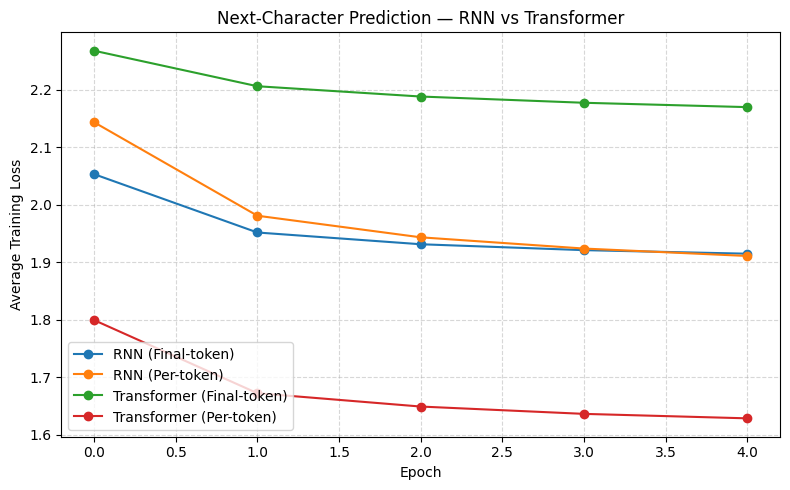

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(loss_rnn_final, label="RNN (Final-token)", marker='o')
plt.plot(loss_rnn_token, label="RNN (Per-token)", marker='o')
plt.plot(loss_trans_final, label="Transformer (Final-token)", marker='o')
plt.plot(loss_trans_token, label="Transformer (Per-token)", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Average Training Loss")
plt.title("Next-Character Prediction — RNN vs Transformer")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
def encode(s):
    return [stoi[c] for c in s if c in stoi]

def decode(indices):
    return "".join([itos[i] for i in indices if i in itos])

In [ ]:
import torch
import torch.nn.functional as F

def generate_text(model, prefix="he", max_new_chars=20, temperature=1.0, top_k=None):
    """
    Generate text character-by-character from a trained RNN or Transformer.

    Args:
        model: trained CharRNN or CharTransformer
        prefix (str): starting string (seed)
        max_new_chars (int): maximum characters to generate
        temperature (float): sampling temperature (1.0 = neutral, <1 = greedy, >1 = more random)
        top_k (int or None): restrict sampling to top-k probable characters

    Returns:
        generated string
    """
    model.eval()
    x = torch.tensor([encode(prefix)], dtype=torch.long)  # [1, T]
    generated = encode(prefix)

    for _ in range(max_new_chars):
        with torch.no_grad():
            logits = model(x)           # [1, T, V]
            next_logits = logits[:, -1, :] / temperature
            probs = F.softmax(next_logits, dim=-1)

            if top_k is not None:
                # restrict to top-k choices for more realistic sampling
                top_probs, top_idx = probs.topk(top_k)
                probs = top_probs / top_probs.sum()
                next_char = top_idx[0, torch.multinomial(probs, 1)].item()
            else:
                next_char = torch.multinomial(probs, 1).item()

            generated.append(next_char)
            x = torch.tensor([generated], dtype=torch.long)

    return decode(generated)

In [ ]:
print("RNN (per-token) samples:")
for start in ["he", "th", "re", "py"]:
    print(f"  {start} → {generate_text(rnn_token, start, max_new_chars=10, top_k=3)}")

print("\nTransformer (per-token) samples:")
for start in ["he", "th", "re", "py"]:
    print(f"  {start} → {generate_text(trans_token, start, max_new_chars=10, top_k=3)}")

RNN (per-token) samples:
  he → hematomallys
  th → theomatophor
  re → reclositedan
  py → pyelingatica

Transformer (per-token) samples:
  he → hehhhhhhhhhh
  th → thtttttttttt
  re → reeeeeeeeeee
  py → pypppppppppp


## NLTK English words

### Dataset

In [ ]:
!pip install nltk tqdm matplotlib --quiet
import nltk, string, random, torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm
import matplotlib.pyplot as plt

nltk.download('words')
from nltk.corpus import words
torch.manual_seed(42)

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


In [ ]:
# Get words corpus
corpus = [w.lower() for w in words.words() if w.isalpha() and len(w) > 2]
print("Number of words:", len(corpus))

# Build vocabulary (letters + <eos>, <pad>)
chars = list(string.ascii_lowercase) + ["<eos>", "<pad>"]
stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for ch, i in stoi.items()}
eos_idx, pad_idx = stoi["<eos>"], stoi["<pad>"]
vocab_size = len(stoi)

def encode(word):
    return [stoi[c] for c in word if c in stoi] + [eos_idx]

def decode(indices):
    return "".join([itos[i] for i in indices if i in itos and itos[i] not in ("<pad>", "<eos>")])

Number of words: 236504


In [ ]:
stoi

{'a': 0,
 'b': 1,
 'c': 2,
 'd': 3,
 'e': 4,
 'f': 5,
 'g': 6,
 'h': 7,
 'i': 8,
 'j': 9,
 'k': 10,
 'l': 11,
 'm': 12,
 'n': 13,
 'o': 14,
 'p': 15,
 'q': 16,
 'r': 17,
 's': 18,
 't': 19,
 'u': 20,
 'v': 21,
 'w': 22,
 'x': 23,
 'y': 24,
 'z': 25,
 '<eos>': 26,
 '<pad>': 27}

In [ ]:
class CharDataset(Dataset):
    def __init__(self, words, mode="final-token"):
        self.mode = mode
        self.data = []

        for w in words:
            seq = encode(w)
            if len(seq) < 2:
                continue
            if mode == "final-token":
                # Predict final character only
                x, y = seq[:-1], seq[-1]
                self.data.append((torch.tensor(x), torch.tensor(y)))
            elif mode == "final-token2":
                # Random prefix (1–len-1) → next char
                # e.g., "hello" → ("hel", "l") or ("hell", "o")
                for i in range(1, len(seq)):
                    prefix, next_char = seq[:i], seq[i]
                    self.data.append((torch.tensor(prefix), torch.tensor(next_char)))
            elif mode == "teacher-forced":
                # Predict every next character
                # Full sequence → shifted sequence
                x, y = seq[:-1], seq[1:]
                self.data.append((torch.tensor(x), torch.tensor(y)))
            else:
                raise ValueError("Invalid mode")

    def __len__(self): return len(self.data)
    def __getitem__(self, idx): return self.data[idx]

# Collate functions
def collate_final(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=pad_idx)
    y_tensor = torch.stack(ys)
    lengths = torch.tensor([len(x) for x in xs])
    return x_padded, y_tensor, lengths

def collate_teacher(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=pad_idx)
    y_padded = pad_sequence(ys, batch_first=True, padding_value=pad_idx)
    return x_padded, y_padded

### Models

In [ ]:
class CharRNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.rnn = nn.RNN(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x):
        emb = self.embed(x)
        out, _ = self.rnn(emb)
        return self.fc(out)

class CharLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, vocab_size)
    def forward(self, x):
        emb = self.embed(x)
        out, _ = self.lstm(emb)
        return self.fc(out)

class CharTransformer(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, nhead=4, num_layers=2):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)
        encoder_layer = nn.TransformerEncoderLayer(embed_dim, nhead, 128, dropout=0.2, batch_first=True)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.fc = nn.Linear(embed_dim, vocab_size)
    def forward(self, x):
        emb = self.embed(x)
        out = self.encoder(emb)
        return self.fc(out)

In [ ]:
def train_model(
    model, dataloader, mode="final-token",
    epochs=10, lr=0.001, clip=1.0,
    early_stop_threshold=0.01, patience=2, lr_decay=0.8
):
    """
    Enhanced training loop with early stopping and learning-rate decay.

    Args:
        model: PyTorch model (RNN, LSTM, Transformer)
        dataloader: DataLoader for training
        mode: 'final-token' or 'teacher-forced'
        epochs: max number of epochs
        lr: learning rate
        clip: gradient clipping max norm
        early_stop_threshold: stop training when avg loss < this value
        patience: consecutive epochs below threshold before stopping
        lr_decay: multiplier to reduce LR if no improvement

    Returns:
        losses: list of average losses per epoch
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_decay, patience=1)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    losses = []
    model.train()

    print(f"🚀 Starting training ({mode}) for up to {epochs} epochs...")
    stop_counter = 0

    for epoch in range(epochs):
        total_loss = 0.0
        num_batches = 0

        for batch in tqdm(dataloader, desc=f"[{mode}] Epoch {epoch+1}/{epochs}", ncols=100):
            optimizer.zero_grad()

            if "final-token" in mode:
                x, y, lengths = batch
                logits = model(x)  # [B, T, V]
                last_outputs = torch.stack(
                    [logits[i, l-1, :] for i, l in enumerate(lengths)], dim=0
                )
                loss = criterion(last_outputs, y)

            elif "teacher-forced" in mode:
                x, y = batch
                logits = model(x)
                loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))

            else:
                raise ValueError(f"Invalid mode: {mode}")

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        # Compute average epoch loss
        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        scheduler.step(avg_loss)  # update LR if plateau
        print(f"✅ Epoch {epoch+1}: avg loss = {avg_loss:.4f}, lr = {optimizer.param_groups[0]['lr']:.5f}")

        # Early stopping condition
        if avg_loss <= early_stop_threshold:
            stop_counter += 1
            print(f"⚠️ Low loss detected ({avg_loss:.4f}), patience {stop_counter}/{patience}")
            if stop_counter >= patience:
                print(f"🛑 Early stopping triggered after {epoch+1} epochs (loss < {early_stop_threshold})")
                break
        else:
            stop_counter = 0  # reset counter if loss rises again

    print(f"🏁 Training completed — best loss: {min(losses):.4f}")
    return losses

In [ ]:
def evaluate_model(model, dataloader, mode="final-token"):
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    total_loss, correct, count = 0, 0, 0
    with torch.no_grad():
        for batch in dataloader:
            if "final-token" in mode:
                x, y, lengths = batch
                logits = model(x)
                last_outputs = torch.stack([logits[i, l-1, :] for i, l in enumerate(lengths)], dim=0)
                loss = criterion(last_outputs, y)
                preds = last_outputs.argmax(1)
                correct += (preds == y).sum().item()
                count += y.size(0)
            elif mode == "teacher-forced":
                x, y = batch
                logits = model(x)
                loss = criterion(logits.view(-1, vocab_size), y.view(-1))
                preds = logits.argmax(2)
                mask = (y != pad_idx)
                correct += ((preds == y) * mask).sum().item()
                count += mask.sum().item()
            total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    acc = correct / count if count > 0 else 0
    print(f"🔍 Evaluation ({mode}) — Loss: {avg_loss:.4f}, Acc: {acc*100:.2f}%")
    return avg_loss, acc

def generate(model, start="he", max_len=12, temperature=0.9, top_k=5):
    model.eval()
    x = torch.tensor([[stoi[c] for c in start]], dtype=torch.long)
    output = start
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(x)[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)
            top_probs, top_idx = probs.topk(top_k)
            top_probs = top_probs / top_probs.sum()
            next_idx = top_idx[0, torch.multinomial(top_probs, 1)].item()
            next_char = itos[next_idx]
            if next_char == "<eos>": break
            output += next_char
            x = torch.cat([x, torch.tensor([[next_idx]])], dim=1)
    return output

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

# Split words — no overlap between train/test sets
train_words, test_words = train_test_split(list(set(corpus)), test_size=0.2, random_state=42)

# Create datasets
train_final = CharDataset(train_words, mode="final-token")
test_final = CharDataset(test_words, mode="final-token")
train_final2 = CharDataset(train_words, mode="final-token2")
test_final2 = CharDataset(test_words, mode="final-token2")
train_teacher = CharDataset(train_words, mode="teacher-forced")
test_teacher = CharDataset(test_words, mode="teacher-forced")

# Dataloaders
batch_size = 128
dl_train_final = DataLoader(train_final, batch_size=batch_size, shuffle=True, collate_fn=collate_final)
dl_test_final = DataLoader(test_final, batch_size=batch_size, collate_fn=collate_final)
dl_train_final2 = DataLoader(train_final2, batch_size=batch_size, shuffle=True, collate_fn=collate_final)
dl_test_final2 = DataLoader(test_final2, batch_size=batch_size, collate_fn=collate_final)
dl_train_teacher = DataLoader(train_teacher, batch_size=batch_size, shuffle=True, collate_fn=collate_teacher)
dl_test_teacher = DataLoader(test_teacher, batch_size=batch_size, collate_fn=collate_teacher)

In [ ]:
import os
os.makedirs("checkpoints", exist_ok=True)

# Define models to train for each architecture and mode
architectures = {
    "RNN": CharRNN,
    "LSTM": CharLSTM,
    "Transformer": CharTransformer
}

modes = ["final-token", "final-token2", "teacher-forced"]

losses, results, saved_models = {}, {}, {}
epochs = 8
for name, ModelClass in architectures.items():
    for mode in modes:
        print(f"\n🚀 Training {name} ({mode})")

        # Model instance (new for each mode)
        model = ModelClass(vocab_size)

        # Define paths for saving/loading
        model_path = f"checkpoints/{name}_{mode}.pt"

        if os.path.exists(model_path):
            print(f"📦 Loading existing {model_path}")
            model.load_state_dict(torch.load(model_path))
        else:
            # Choose the correct dataloaders for this mode
            if mode == "final-token":
                train_loader, test_loader = dl_train_final, dl_test_final
            elif mode == "final-token2":
                train_loader, test_loader = dl_train_final2, dl_test_final2
            elif mode == "teacher-forced":
                train_loader, test_loader = dl_train_teacher, dl_test_teacher

            # Train and evaluate
            losses[f"{name}-{mode}"] = train_model(model, train_loader, mode=mode, epochs=epochs)
            results[f"{name}-{mode}"] = evaluate_model(model, test_loader, mode=mode)

            # Save model
            torch.save(model.state_dict(), model_path)
            print(f"💾 Saved {model_path}")

        # Keep reference for later generation
        saved_models[f"{name}-{mode}"] = model


🚀 Training RNN (final-token)
🚀 Starting training (final-token) for up to 8 epochs...


[final-token] Epoch 1/8: 100%|██████████████████████████████████| 1464/1464 [00:15<00:00, 94.07it/s]


✅ Epoch 1: avg loss = 0.0159, lr = 0.00100


[final-token] Epoch 2/8: 100%|██████████████████████████████████| 1464/1464 [00:16<00:00, 90.36it/s]


✅ Epoch 2: avg loss = 0.0000, lr = 0.00100
⚠️ Low loss detected (0.0000), patience 1/2


[final-token] Epoch 3/8: 100%|██████████████████████████████████| 1464/1464 [00:15<00:00, 93.39it/s]


✅ Epoch 3: avg loss = 0.0000, lr = 0.00100
⚠️ Low loss detected (0.0000), patience 2/2
🛑 Early stopping triggered after 3 epochs (loss < 0.01)
🏁 Training completed — best loss: 0.0000
🔍 Evaluation (final-token) — Loss: 0.0000, Acc: 100.00%
💾 Saved checkpoints/RNN_final-token.pt

🚀 Training RNN (final-token2)
🚀 Starting training (final-token2) for up to 8 epochs...


[final-token2] Epoch 1/8: 100%|███████████████████████████████| 14052/14052 [02:22<00:00, 98.34it/s]


✅ Epoch 1: avg loss = 2.0157, lr = 0.00100


[final-token2] Epoch 2/8: 100%|███████████████████████████████| 14052/14052 [02:21<00:00, 99.05it/s]


✅ Epoch 2: avg loss = 1.9119, lr = 0.00100


[final-token2] Epoch 3/8: 100%|███████████████████████████████| 14052/14052 [02:22<00:00, 98.76it/s]


✅ Epoch 3: avg loss = 1.8903, lr = 0.00100


[final-token2] Epoch 4/8: 100%|███████████████████████████████| 14052/14052 [02:22<00:00, 98.56it/s]


✅ Epoch 4: avg loss = 1.8796, lr = 0.00100


[final-token2] Epoch 5/8: 100%|██████████████████████████████| 14052/14052 [02:19<00:00, 100.76it/s]


✅ Epoch 5: avg loss = 1.8728, lr = 0.00100


[final-token2] Epoch 6/8: 100%|██████████████████████████████| 14052/14052 [02:15<00:00, 103.55it/s]


✅ Epoch 6: avg loss = 1.8684, lr = 0.00100


[final-token2] Epoch 7/8: 100%|██████████████████████████████| 14052/14052 [02:16<00:00, 102.80it/s]


✅ Epoch 7: avg loss = 1.8650, lr = 0.00100


[final-token2] Epoch 8/8: 100%|██████████████████████████████| 14052/14052 [02:16<00:00, 102.76it/s]


✅ Epoch 8: avg loss = 1.8625, lr = 0.00100
🏁 Training completed — best loss: 1.8625
🔍 Evaluation (final-token2) — Loss: 1.8735, Acc: 40.35%
💾 Saved checkpoints/RNN_final-token2.pt

🚀 Training RNN (teacher-forced)
🚀 Starting training (teacher-forced) for up to 8 epochs...


[teacher-forced] Epoch 1/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 199.57it/s]


✅ Epoch 1: avg loss = 2.1265, lr = 0.00100


[teacher-forced] Epoch 2/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 198.85it/s]


✅ Epoch 2: avg loss = 1.9543, lr = 0.00100


[teacher-forced] Epoch 3/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 196.64it/s]


✅ Epoch 3: avg loss = 1.9114, lr = 0.00100


[teacher-forced] Epoch 4/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 198.92it/s]


✅ Epoch 4: avg loss = 1.8884, lr = 0.00100


[teacher-forced] Epoch 5/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 200.43it/s]


✅ Epoch 5: avg loss = 1.8739, lr = 0.00100


[teacher-forced] Epoch 6/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 196.72it/s]


✅ Epoch 6: avg loss = 1.8634, lr = 0.00100


[teacher-forced] Epoch 7/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 197.05it/s]


✅ Epoch 7: avg loss = 1.8555, lr = 0.00100


[teacher-forced] Epoch 8/8: 100%|██████████████████████████████| 1464/1464 [00:07<00:00, 196.16it/s]


✅ Epoch 8: avg loss = 1.8496, lr = 0.00100
🏁 Training completed — best loss: 1.8496
🔍 Evaluation (teacher-forced) — Loss: 1.8595, Acc: 40.70%
💾 Saved checkpoints/RNN_teacher-forced.pt

🚀 Training LSTM (final-token)
🚀 Starting training (final-token) for up to 8 epochs...


[final-token] Epoch 1/8: 100%|██████████████████████████████████| 1464/1464 [00:17<00:00, 81.97it/s]


✅ Epoch 1: avg loss = 0.0272, lr = 0.00100


[final-token] Epoch 2/8: 100%|██████████████████████████████████| 1464/1464 [00:17<00:00, 81.55it/s]


✅ Epoch 2: avg loss = 0.0000, lr = 0.00100
⚠️ Low loss detected (0.0000), patience 1/2


[final-token] Epoch 3/8: 100%|██████████████████████████████████| 1464/1464 [00:17<00:00, 81.86it/s]


✅ Epoch 3: avg loss = 0.0000, lr = 0.00100
⚠️ Low loss detected (0.0000), patience 2/2
🛑 Early stopping triggered after 3 epochs (loss < 0.01)
🏁 Training completed — best loss: 0.0000
🔍 Evaluation (final-token) — Loss: 0.0000, Acc: 100.00%
💾 Saved checkpoints/LSTM_final-token.pt

🚀 Training LSTM (final-token2)
🚀 Starting training (final-token2) for up to 8 epochs...


[final-token2] Epoch 1/8: 100%|███████████████████████████████| 14052/14052 [02:50<00:00, 82.65it/s]


✅ Epoch 1: avg loss = 1.9364, lr = 0.00100


[final-token2] Epoch 2/8: 100%|███████████████████████████████| 14052/14052 [02:50<00:00, 82.30it/s]


✅ Epoch 2: avg loss = 1.7883, lr = 0.00100


[final-token2] Epoch 3/8: 100%|███████████████████████████████| 14052/14052 [02:57<00:00, 79.08it/s]


✅ Epoch 3: avg loss = 1.7465, lr = 0.00100


[final-token2] Epoch 4/8: 100%|███████████████████████████████| 14052/14052 [02:58<00:00, 78.85it/s]


✅ Epoch 4: avg loss = 1.7221, lr = 0.00100


[final-token2] Epoch 5/8: 100%|███████████████████████████████| 14052/14052 [02:59<00:00, 78.32it/s]


✅ Epoch 5: avg loss = 1.7057, lr = 0.00100


[final-token2] Epoch 6/8: 100%|███████████████████████████████| 14052/14052 [03:01<00:00, 77.53it/s]


✅ Epoch 6: avg loss = 1.6942, lr = 0.00100


[final-token2] Epoch 7/8: 100%|███████████████████████████████| 14052/14052 [02:58<00:00, 78.52it/s]


✅ Epoch 7: avg loss = 1.6850, lr = 0.00100


[final-token2] Epoch 8/8: 100%|███████████████████████████████| 14052/14052 [02:50<00:00, 82.22it/s]


✅ Epoch 8: avg loss = 1.6774, lr = 0.00100
🏁 Training completed — best loss: 1.6774
🔍 Evaluation (final-token2) — Loss: 1.7057, Acc: 45.45%
💾 Saved checkpoints/LSTM_final-token2.pt

🚀 Training LSTM (teacher-forced)
🚀 Starting training (teacher-forced) for up to 8 epochs...


[teacher-forced] Epoch 1/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 130.34it/s]


✅ Epoch 1: avg loss = 2.0934, lr = 0.00100


[teacher-forced] Epoch 2/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 129.45it/s]


✅ Epoch 2: avg loss = 1.8732, lr = 0.00100


[teacher-forced] Epoch 3/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 131.41it/s]


✅ Epoch 3: avg loss = 1.8134, lr = 0.00100


[teacher-forced] Epoch 4/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 129.10it/s]


✅ Epoch 4: avg loss = 1.7786, lr = 0.00100


[teacher-forced] Epoch 5/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 128.84it/s]


✅ Epoch 5: avg loss = 1.7550, lr = 0.00100


[teacher-forced] Epoch 6/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 130.38it/s]


✅ Epoch 6: avg loss = 1.7370, lr = 0.00100


[teacher-forced] Epoch 7/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 130.03it/s]


✅ Epoch 7: avg loss = 1.7231, lr = 0.00100


[teacher-forced] Epoch 8/8: 100%|██████████████████████████████| 1464/1464 [00:11<00:00, 132.45it/s]


✅ Epoch 8: avg loss = 1.7119, lr = 0.00100
🏁 Training completed — best loss: 1.7119
🔍 Evaluation (teacher-forced) — Loss: 1.7291, Acc: 44.64%
💾 Saved checkpoints/LSTM_teacher-forced.pt

🚀 Training Transformer (final-token)
🚀 Starting training (final-token) for up to 8 epochs...


[final-token] Epoch 1/8: 100%|██████████████████████████████████| 1464/1464 [00:24<00:00, 60.62it/s]


✅ Epoch 1: avg loss = 0.0170, lr = 0.00100


[final-token] Epoch 2/8: 100%|██████████████████████████████████| 1464/1464 [00:24<00:00, 60.31it/s]


✅ Epoch 2: avg loss = 0.0000, lr = 0.00100
⚠️ Low loss detected (0.0000), patience 1/2


[final-token] Epoch 3/8: 100%|██████████████████████████████████| 1464/1464 [00:23<00:00, 61.21it/s]


✅ Epoch 3: avg loss = 0.0000, lr = 0.00100
⚠️ Low loss detected (0.0000), patience 2/2
🛑 Early stopping triggered after 3 epochs (loss < 0.01)
🏁 Training completed — best loss: 0.0000
🔍 Evaluation (final-token) — Loss: 0.0000, Acc: 100.00%
💾 Saved checkpoints/Transformer_final-token.pt

🚀 Training Transformer (final-token2)
🚀 Starting training (final-token2) for up to 8 epochs...


[final-token2] Epoch 1/8: 100%|███████████████████████████████| 14052/14052 [03:41<00:00, 63.40it/s]


✅ Epoch 1: avg loss = 2.2720, lr = 0.00100


[final-token2] Epoch 2/8: 100%|███████████████████████████████| 14052/14052 [03:41<00:00, 63.45it/s]


✅ Epoch 2: avg loss = 2.2108, lr = 0.00100


[final-token2] Epoch 3/8: 100%|███████████████████████████████| 14052/14052 [03:40<00:00, 63.74it/s]


✅ Epoch 3: avg loss = 2.1917, lr = 0.00100


[final-token2] Epoch 4/8: 100%|███████████████████████████████| 14052/14052 [03:40<00:00, 63.60it/s]


✅ Epoch 4: avg loss = 2.1815, lr = 0.00100


[final-token2] Epoch 5/8: 100%|███████████████████████████████| 14052/14052 [03:41<00:00, 63.44it/s]


✅ Epoch 5: avg loss = 2.1745, lr = 0.00100


[final-token2] Epoch 6/8: 100%|███████████████████████████████| 14052/14052 [03:41<00:00, 63.38it/s]


✅ Epoch 6: avg loss = 2.1688, lr = 0.00100


[final-token2] Epoch 7/8: 100%|███████████████████████████████| 14052/14052 [03:41<00:00, 63.43it/s]


✅ Epoch 7: avg loss = 2.1649, lr = 0.00100


[final-token2] Epoch 8/8: 100%|███████████████████████████████| 14052/14052 [03:40<00:00, 63.68it/s]


✅ Epoch 8: avg loss = 2.1614, lr = 0.00100
🏁 Training completed — best loss: 2.1614
🔍 Evaluation (final-token2) — Loss: 2.1197, Acc: 31.55%
💾 Saved checkpoints/Transformer_final-token2.pt

🚀 Training Transformer (teacher-forced)
🚀 Starting training (teacher-forced) for up to 8 epochs...


[teacher-forced] Epoch 1/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 89.38it/s]


✅ Epoch 1: avg loss = 1.8545, lr = 0.00100


[teacher-forced] Epoch 2/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 89.70it/s]


✅ Epoch 2: avg loss = 1.6962, lr = 0.00100


[teacher-forced] Epoch 3/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 89.62it/s]


✅ Epoch 3: avg loss = 1.6644, lr = 0.00100


[teacher-forced] Epoch 4/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 89.29it/s]


✅ Epoch 4: avg loss = 1.6484, lr = 0.00100


[teacher-forced] Epoch 5/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 88.64it/s]


✅ Epoch 5: avg loss = 1.6386, lr = 0.00100


[teacher-forced] Epoch 6/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 89.34it/s]


✅ Epoch 6: avg loss = 1.6317, lr = 0.00100


[teacher-forced] Epoch 7/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 89.24it/s]


✅ Epoch 7: avg loss = 1.6267, lr = 0.00100


[teacher-forced] Epoch 8/8: 100%|███████████████████████████████| 1464/1464 [00:16<00:00, 90.05it/s]


✅ Epoch 8: avg loss = 1.6229, lr = 0.00100
🏁 Training completed — best loss: 1.6229
🔍 Evaluation (teacher-forced) — Loss: 1.5235, Acc: 42.36%
💾 Saved checkpoints/Transformer_teacher-forced.pt


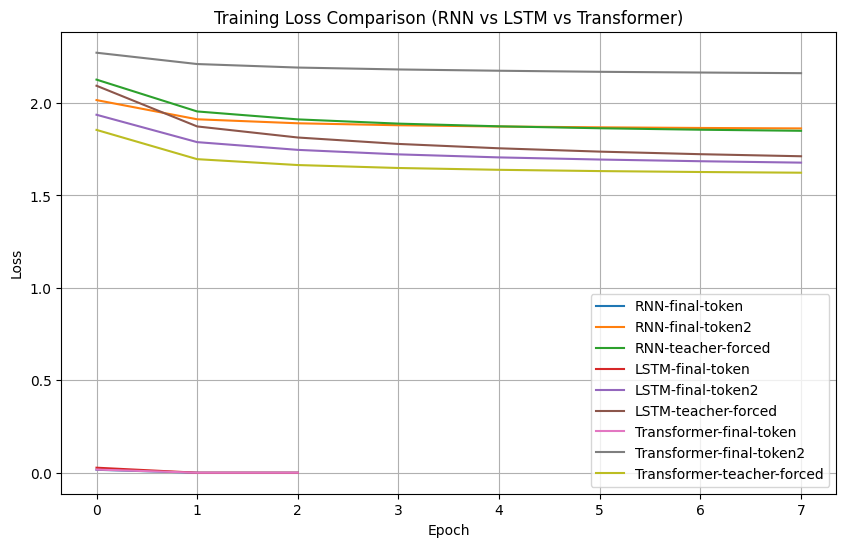

In [ ]:
plt.figure(figsize=(10,6))
for k, v in losses.items():
    plt.plot(v, label=k)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Comparison (RNN vs LSTM vs Transformer)")
plt.legend()
plt.grid(True)
plt.show()

### Testing

In [ ]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [ ]:
def load_trained_model(model_name, mode, vocab_size, checkpoint_dir="checkpoints"):
    """
    Load a trained model from disk based on its name and training mode.

    Args:
        model_name (str): 'RNN', 'LSTM', or 'Transformer'
        mode (str): 'final-token' or 'teacher-forced'
        vocab_size (int): vocabulary size
        checkpoint_dir (str): directory containing saved .pt models

    Returns:
        model: loaded PyTorch model ready for evaluation
    """
    model_classes = {
        "RNN": CharRNN,
        "LSTM": CharLSTM,
        "Transformer": CharTransformer
    }

    if model_name not in model_classes:
        raise ValueError(f"Unknown model: {model_name}. Choose from {list(model_classes.keys())}")

    filename = f"{model_name}_{mode}.pt"
    path = os.path.join(checkpoint_dir, filename)

    if not os.path.exists(path):
        raise FileNotFoundError(f"❌ No checkpoint found: {path}")

    model = model_classes[model_name](vocab_size)
    model.load_state_dict(torch.load(path, map_location="cpu"))
    model.eval()
    print(f"✅ Loaded model from {path}")
    return model

In [ ]:
import torch
import torch.nn.functional as F

def generate_word(
    model, start="he", max_len=12, sampling="greedy",
    temperature=1.0, top_k=5, top_p=0.9
):
    model.eval()
    x = torch.tensor([[stoi[c] for c in start if c in stoi]], dtype=torch.long)
    generated = start
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(x)[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            if sampling == "greedy":
                next_idx = probs.argmax(dim=-1).item()

            elif sampling == "temperature":
                next_idx = torch.multinomial(probs, 1).item()

            elif sampling == "top-k":
                top_probs, top_idx = probs.topk(top_k)
                top_probs = top_probs / top_probs.sum()
                next_idx = top_idx[0, torch.multinomial(top_probs, 1)].item()

            elif sampling == "top-p":
                # Sort by probability
                sorted_probs, sorted_idx = torch.sort(probs, descending=True)
                cumulative = torch.cumsum(sorted_probs, dim=-1)

                # Keep smallest set of tokens with cumulative prob <= top_p
                mask = cumulative > top_p
                sorted_probs[mask] = 0.0

                total = sorted_probs.sum()
                if total.item() == 0 or torch.isnan(total):  # fallback case
                    next_idx = sorted_idx[0, 0].item()  # fallback to most probable token
                else:
                    sorted_probs = sorted_probs / total
                    next_idx = sorted_idx[0, torch.multinomial(sorted_probs, 1)].item()
            else:
                raise ValueError(f"Invalid sampling type: {sampling}")

            next_char = itos[next_idx]
            if next_char == "<eos>":
                break
            generated += next_char
            x = torch.cat([x, torch.tensor([[next_idx]])], dim=1)
    return generated


In [ ]:
def run_generation_examples(model, model_name, mode, prompts=None, max_len=12):
    if prompts is None:
        prompts = ["he", "py", "ne", "tr", "mo"]

    sampling_modes = ["greedy", "temperature", "top-k", "top-p"]
    print(f"\n🎨 {model_name} ({mode}) — Generation Examples")

    for prefix in prompts:
        print(f"\nPrompt: '{prefix}'")
        for sm in sampling_modes:
            text = generate_word(model, start=prefix, sampling=sm, temperature=0.9, top_k=5, top_p=0.9, max_len=max_len)
            print(f"  {sm:<12} → {text}")

In [ ]:
# Load the models you want to test
model_name = "RNN"           # or "LSTM", "Transformer"
modes = ["final-token", "final-token2", "teacher-forced"]

for mode in modes:
    model = load_trained_model(model_name, mode, vocab_size)
    # Evaluate on test data
    if mode == "final-token":
        evaluate_model(model, dl_test_final, mode)
    elif mode == "final-token2":
        evaluate_model(model, dl_test_final2, mode)
    else:
        evaluate_model(model, dl_test_teacher, mode)
    # Generate qualitative examples
    run_generation_examples(model, model_name, mode)

<ipython-input-12-821b78f2d951>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location="cpu"))


✅ Loaded model from checkpoints/RNN_final-token.pt
🔍 Evaluation (final-token) — Loss: 0.0000, Acc: 100.00%

🎨 RNN (final-token) — Generation Examples

Prompt: 'he'
  greedy       → he
  temperature  → he
  top-k        → he
  top-p        → he

Prompt: 'py'
  greedy       → py
  temperature  → py
  top-k        → py
  top-p        → py

Prompt: 'ne'
  greedy       → ne
  temperature  → ne
  top-k        → ne
  top-p        → ne

Prompt: 'tr'
  greedy       → tr
  temperature  → tr
  top-k        → tr
  top-p        → tr

Prompt: 'mo'
  greedy       → mo
  temperature  → mo
  top-k        → mo
  top-p        → mo
✅ Loaded model from checkpoints/RNN_final-token2.pt
🔍 Evaluation (final-token2) — Loss: 1.8735, Acc: 40.35%

🎨 RNN (final-token2) — Generation Examples

Prompt: 'he'
  greedy       → hemicophoric
  temperature  → hellage
  top-k        → hereterium
  top-p        → heximatophore

Prompt: 'py'
  greedy       → pyrosis
  temperature  → pyramis
  top-k        → pyreclesis
  top-p 

In [ ]:
# Load the models you want to test
model_name = "LSTM"           # or "RNN", "Transformer"
modes = ["final-token", "final-token2", "teacher-forced"]

for mode in modes:
    model = load_trained_model(model_name, mode, vocab_size)
    # Evaluate on test data
    if mode == "final-token":
        evaluate_model(model, dl_test_final, mode)
    elif mode == "final-token2":
        evaluate_model(model, dl_test_final2, mode)
    else:
        evaluate_model(model, dl_test_teacher, mode)

<ipython-input-12-821b78f2d951>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location="cpu"))


✅ Loaded model from checkpoints/LSTM_final-token.pt
🔍 Evaluation (final-token) — Loss: 0.0000, Acc: 100.00%
✅ Loaded model from checkpoints/LSTM_final-token2.pt
🔍 Evaluation (final-token2) — Loss: 1.7057, Acc: 45.45%
✅ Loaded model from checkpoints/LSTM_teacher-forced.pt
🔍 Evaluation (teacher-forced) — Loss: 1.7291, Acc: 44.64%


In [ ]:
# Load the models you want to test
model_name = "LSTM"           # or "LSTM", "Transformer"
modes = ["final-token", "final-token2", "teacher-forced"]

for mode in modes:
    model = load_trained_model(model_name, mode, vocab_size)
    # Evaluate on test data
    if mode == "final-token":
        evaluate_model(model, dl_test_final, mode)
    elif mode == "final-token2":
        evaluate_model(model, dl_test_final2, mode)
    else:
        evaluate_model(model, dl_test_teacher, mode)
    # Generate qualitative examples
    run_generation_examples(model, model_name, mode)

<ipython-input-12-821b78f2d951>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location="cpu"))


✅ Loaded model from checkpoints/LSTM_final-token.pt
🔍 Evaluation (final-token) — Loss: 0.0000, Acc: 100.00%

🎨 LSTM (final-token) — Generation Examples

Prompt: 'he'
  greedy       → he
  temperature  → he
  top-k        → he
  top-p        → he

Prompt: 'py'
  greedy       → py
  temperature  → py
  top-k        → py
  top-p        → py

Prompt: 'ne'
  greedy       → ne
  temperature  → ne
  top-k        → ne
  top-p        → ne

Prompt: 'tr'
  greedy       → tr
  temperature  → tr
  top-k        → tr
  top-p        → tr

Prompt: 'mo'
  greedy       → mo
  temperature  → mo
  top-k        → mo
  top-p        → mo
✅ Loaded model from checkpoints/LSTM_final-token2.pt
🔍 Evaluation (final-token2) — Loss: 1.7057, Acc: 45.45%

🎨 LSTM (final-token2) — Generation Examples

Prompt: 'he'
  greedy       → hemiprose
  temperature  → heartblary
  top-k        → hemocratist
  top-p        → heralgian

Prompt: 'py'
  greedy       → pyrometrical
  temperature  → pygeoiterist
  top-k        → pyracoly

In [ ]:
# Load the models you want to test
model_name = "Transformer"           # or "RNN", "Transformer"
modes = ["final-token", "final-token2", "teacher-forced"]

for mode in modes:
    model = load_trained_model(model_name, mode, vocab_size)
    # Evaluate on test data
    if mode == "final-token":
        evaluate_model(model, dl_test_final, mode)
    elif mode == "final-token2":
        evaluate_model(model, dl_test_final2, mode)
    else:
        evaluate_model(model, dl_test_teacher, mode)
    # Generate qualitative examples
    run_generation_examples(model, model_name, mode)

<ipython-input-12-821b78f2d951>:30: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(path, map_location="cpu"))


✅ Loaded model from checkpoints/Transformer_final-token.pt
🔍 Evaluation (final-token) — Loss: 0.0000, Acc: 100.00%

🎨 Transformer (final-token) — Generation Examples

Prompt: 'he'
  greedy       → he
  temperature  → he
  top-k        → he
  top-p        → he

Prompt: 'py'
  greedy       → py
  temperature  → py
  top-k        → py
  top-p        → py

Prompt: 'ne'
  greedy       → ne
  temperature  → ne
  top-k        → ne
  top-p        → ne

Prompt: 'tr'
  greedy       → tr
  temperature  → tr
  top-k        → tr
  top-p        → tr

Prompt: 'mo'
  greedy       → mo
  temperature  → mo
  top-k        → mo
  top-p        → mo
✅ Loaded model from checkpoints/Transformer_final-token2.pt
🔍 Evaluation (final-token2) — Loss: 2.1197, Acc: 31.55%

🎨 Transformer (final-token2) — Generation Examples

Prompt: 'he'
  greedy       → he
  temperature  → heaeh
  top-k        → hesip
  top-p        → heee

Prompt: 'py'
  greedy       → pyoi
  temperature  → pyeua
  top-k        → pyroi
  top-p     

## Improvement

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F


# --------------------------------------
# Positional Encoding: injects order info
# --------------------------------------
class PositionalEncoding(nn.Module):
    """
    Implements standard sinusoidal positional encoding used in the original Transformer paper:
    "Attention Is All You Need" (Vaswani et al., 2017).

    Each position in the sequence gets a unique combination of sine and cosine values
    that allows the model to learn relative positions without explicit recurrence.
    """

    def __init__(self, d_model, max_len=5000):
        super().__init__()
        # Create a matrix of shape [max_len, d_model]
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]

        # Compute sinusoidal frequencies
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                             (-math.log(10000.0) / d_model))
        # Apply sin to even indices, cos to odd indices
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Register buffer so it’s not a learnable parameter but saved in the model state
        self.register_buffer('pe', pe.unsqueeze(0))  # [1, max_len, d_model]

    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len, d_model] — the embedded tokens
        Returns:
            x + positional encoding of the same shape
        """
        seq_len = x.size(1)
        # Add positional encoding up to the input length
        return x + self.pe[:, :seq_len, :]


# ----------------------------------------------------------
# Helper: generate a causal mask (prevent look-ahead attention)
# ----------------------------------------------------------
def generate_causal_mask(seq_len, device):
    """
    Creates an upper-triangular mask (filled with -inf) for attention
    so that position i can only attend to positions ≤ i (no future info).

    Returns:
        mask: [seq_len, seq_len] float tensor suitable for TransformerEncoder
    """
    mask = torch.triu(torch.ones(seq_len, seq_len, device=device), diagonal=1)
    mask = mask.masked_fill(mask == 1, float('-inf'))
    return mask


# ----------------------------------------------------------
# Improved Character-Level Transformer
# ----------------------------------------------------------
class CharTransformer(nn.Module):
    """
    Character-level Transformer for next-token (autoregressive) prediction.

    Features:
    - Embedding + PositionalEncoding for ordered input representation.
    - TransformerEncoder stack with causal mask for autoregressive training.
    - Fully-connected output layer to predict next character distribution.
    - Dropout and normalization for training stability.
    """

    def __init__(self,
                 vocab_size,
                 embed_dim=128,
                 num_layers=4,
                 nhead=8,
                 ff_dim=512,
                 dropout=0.1,
                 max_len=500):
        super().__init__()
        self.embed_dim = embed_dim
        self.vocab_size = vocab_size

        # Token embedding (convert integer indices to dense vectors)
        self.embed = nn.Embedding(vocab_size, embed_dim, padding_idx=pad_idx)

        # Positional encoding to inject order information
        self.positional_encoding = PositionalEncoding(embed_dim, max_len=max_len)

        # Transformer encoder layer definition
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=embed_dim,
            nhead=nhead,
            dim_feedforward=ff_dim,
            dropout=dropout,
            batch_first=True,  # so we can use [B, T, E] input format
            activation='gelu'  # smoother activation than ReLU
        )

        # Stack multiple layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        # Final projection layer to vocab size (predict logits over characters)
        self.fc_out = nn.Linear(embed_dim, vocab_size)

        # Regularization
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(embed_dim)

        # Initialize parameters (helps with stable convergence)
        self._init_weights()

    # --------------------------------------
    # Weight initialization
    # --------------------------------------
    def _init_weights(self):
        for name, p in self.named_parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
            elif "bias" in name:
                nn.init.constant_(p, 0)

    # --------------------------------------
    # Forward pass
    # --------------------------------------
    def forward(self, x):
        """
        Args:
            x: [batch_size, seq_len] — token indices
        Returns:
            logits: [batch_size, seq_len, vocab_size]
        """
        device = x.device
        seq_len = x.size(1)

        # Step 1: Token embedding + positional encoding
        x = self.embed(x) * math.sqrt(self.embed_dim)
        x = self.positional_encoding(x)
        x = self.layer_norm(x)
        x = self.dropout(x)

        # Step 2: Create causal mask for autoregressive prediction
        mask = generate_causal_mask(seq_len, device)

        # Step 3: Pass through Transformer Encoder
        out = self.encoder(x, mask)

        # Step 4: Project each position to vocab-size logits
        logits = self.fc_out(out)
        return logits


In [ ]:
# Instantiate model
model = CharTransformer(
    vocab_size=vocab_size,
    embed_dim=128,
    num_layers=4,
    nhead=8,
    ff_dim=512,
    dropout=0.1
)

# Forward pass example
x = torch.randint(0, vocab_size, (8, 20))  # [batch=8, seq_len=20]
logits = model(x)                           # [8, 20, vocab_size]
print(logits.shape)


torch.Size([8, 20, 28])


In [ ]:
import math
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm


def train_transformer(
    model,
    dataloader,
    epochs=10,
    lr=0.001,
    clip=1.0,
    early_stop_threshold=0.01,
    patience=2,
    lr_decay=0.8,
    checkpoint_path=None,
):
    """
    Train the improved CharTransformer model with teacher-forced next-character prediction.

    Args:
        model: CharTransformer instance.
        dataloader: PyTorch DataLoader for training data.
        epochs: Maximum number of epochs.
        lr: Initial learning rate.
        clip: Gradient clipping norm.
        early_stop_threshold: Stop if loss < threshold for several epochs.
        patience: Number of consecutive epochs below threshold before stopping.
        lr_decay: Factor for ReduceLROnPlateau scheduler.
        checkpoint_path: Optional file path to save best model.
    """
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=lr_decay, patience=1)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    model.train()

    best_loss = float("inf")
    losses = []
    stop_counter = 0

    print(f"🚀 Starting training for {epochs} epochs (Transformer)...")

    for epoch in range(epochs):
        total_loss, num_batches = 0.0, 0
        for x, y in tqdm(dataloader, desc=f"[Transformer] Epoch {epoch+1}/{epochs}", ncols=100):
            optimizer.zero_grad()
            logits = model(x)                   # [B, T, V]
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            loss.backward()

            torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
            optimizer.step()

            total_loss += loss.item()
            num_batches += 1

        avg_loss = total_loss / num_batches
        losses.append(avg_loss)
        scheduler.step(avg_loss)

        print(f"✅ Epoch {epoch+1}: loss={avg_loss:.4f}, lr={optimizer.param_groups[0]['lr']:.6f}")

        # Early stopping
        if avg_loss < best_loss:
            best_loss = avg_loss
            if checkpoint_path:
                torch.save(model.state_dict(), checkpoint_path)
                print(f"💾 Saved best model to {checkpoint_path}")
        if avg_loss <= early_stop_threshold:
            stop_counter += 1
            print(f"⚠️ Low loss ({avg_loss:.4f}), patience {stop_counter}/{patience}")
            if stop_counter >= patience:
                print(f"🛑 Early stopping triggered (loss < {early_stop_threshold})")
                break
        else:
            stop_counter = 0

    print(f"🏁 Training complete. Best loss: {best_loss:.4f}")
    return losses


In [ ]:
import math

def evaluate_transformer(model, dataloader):
    """
    Evaluate the CharTransformer model.
    Computes average loss, accuracy, and perplexity.

    Args:
        model: trained Transformer model
        dataloader: DataLoader for validation/test set
    """
    model.eval()
    criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
    total_loss, correct, count = 0.0, 0, 0

    with torch.no_grad():
        for x, y in dataloader:
            logits = model(x)
            loss = criterion(logits.view(-1, logits.size(-1)), y.view(-1))
            total_loss += loss.item()

            preds = logits.argmax(2)
            mask = (y != pad_idx)
            correct += ((preds == y) * mask).sum().item()
            count += mask.sum().item()

    avg_loss = total_loss / len(dataloader)
    accuracy = correct / count if count > 0 else 0.0
    perplexity = math.exp(avg_loss)
    print(f"🔍 Evaluation — Loss: {avg_loss:.4f}, Accuracy: {accuracy*100:.2f}%, Perplexity: {perplexity:.2f}")
    return avg_loss, accuracy, perplexity


In [ ]:
# Instantiate the improved Transformer
model = CharTransformer(
    vocab_size=vocab_size,
    embed_dim=128,
    num_layers=4,
    nhead=8,
    ff_dim=512,
    dropout=0.1
)

# Train the Transformer
checkpoint = "checkpoints/CharTransformer_teacher-forced.pt"
losses = train_transformer(
    model,
    dataloader=dl_train_teacher,
    epochs=10,
    lr=0.001,
    clip=1.0,
    early_stop_threshold=0.02,
    patience=2,
    checkpoint_path=checkpoint
)

# Evaluate on test data
evaluate_transformer(model, dl_test_teacher)


🚀 Starting training for 10 epochs (Transformer)...


[Transformer] Epoch 1/10: 100%|█████████████████████████████████| 1464/1464 [01:21<00:00, 17.93it/s]


✅ Epoch 1: loss=2.0946, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 2/10: 100%|█████████████████████████████████| 1464/1464 [01:21<00:00, 17.95it/s]


✅ Epoch 2: loss=1.9149, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 3/10: 100%|█████████████████████████████████| 1464/1464 [01:20<00:00, 18.09it/s]


✅ Epoch 3: loss=1.8527, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 4/10: 100%|█████████████████████████████████| 1464/1464 [01:20<00:00, 18.12it/s]


✅ Epoch 4: loss=1.8154, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 5/10: 100%|█████████████████████████████████| 1464/1464 [01:21<00:00, 18.07it/s]


✅ Epoch 5: loss=1.7896, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 6/10: 100%|█████████████████████████████████| 1464/1464 [01:21<00:00, 18.01it/s]


✅ Epoch 6: loss=1.7709, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 7/10: 100%|█████████████████████████████████| 1464/1464 [01:20<00:00, 18.14it/s]


✅ Epoch 7: loss=1.7562, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 8/10: 100%|█████████████████████████████████| 1464/1464 [01:21<00:00, 17.99it/s]


✅ Epoch 8: loss=1.7433, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 9/10: 100%|█████████████████████████████████| 1464/1464 [01:21<00:00, 18.04it/s]


✅ Epoch 9: loss=1.7332, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt


[Transformer] Epoch 10/10: 100%|████████████████████████████████| 1464/1464 [01:21<00:00, 17.97it/s]


✅ Epoch 10: loss=1.7252, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer_teacher-forced.pt
🏁 Training complete. Best loss: 1.7252
🔍 Evaluation — Loss: 1.6553, Accuracy: 46.17%, Perplexity: 5.23


(1.6552638509234443, 0.46170613539004124, 5.234460857320488)

In [ ]:
def generate_text(model, start="he", max_len=15, temperature=0.9, top_k=5, top_p=0.9):
    model.eval()
    x = torch.tensor([[stoi[c] for c in start if c in stoi]], dtype=torch.long)
    generated = start
    with torch.no_grad():
        for _ in range(max_len):
            logits = model(x)[:, -1, :] / temperature
            probs = F.softmax(logits, dim=-1)

            # Safe top-p / top-k sampling
            sorted_probs, sorted_idx = torch.sort(probs, descending=True)
            cumulative = torch.cumsum(sorted_probs, dim=-1)
            mask = cumulative > top_p
            sorted_probs[mask] = 0.0
            total = sorted_probs.sum()
            if total <= 0 or torch.isnan(total):
                next_idx = sorted_idx[0, 0].item()
            else:
                sorted_probs = sorted_probs / total
                next_idx = sorted_idx[0, torch.multinomial(sorted_probs, 1)].item()

            next_char = itos[next_idx]
            if next_char == "<eos>": break
            generated += next_char
            x = torch.cat([x, torch.tensor([[next_idx]])], dim=1)
    return generated


In [ ]:
def showcase_generation(model, prefixes=None, max_len=15):
    """
    Generate multiple qualitative examples using different sampling strategies.
    Demonstrates how temperature, top-k, and top-p affect diversity.

    Args:
        model: trained CharTransformer
        prefixes: list of prompt strings
        max_len: maximum length for generated text
    """
    if prefixes is None:
        prefixes = ["he", "py", "ne", "tr", "mo", "de", "su", "ca"]

    print("🎨 Character Transformer — Generation Showcase\n")
    for prefix in prefixes:
        print(f"\nPrompt: '{prefix}'")

        # Greedy decoding — most probable token every time
        out_greedy = generate_text(model, start=prefix, max_len=max_len,
                                   temperature=1.0, top_p=1.0)
        print(f"  greedy       → {out_greedy}")

        # Moderate creativity (temperature sampling)
        out_temp = generate_text(model, start=prefix, max_len=max_len,
                                 temperature=1.1, top_p=0.9)
        print(f"  temperature  → {out_temp}")

        # Top-k sampling (limits to most likely tokens)
        out_topk = generate_text(model, start=prefix, max_len=max_len,
                                 temperature=0.9, top_k=8)
        print(f"  top-k (k=8)  → {out_topk}")

        # Top-p (nucleus) sampling (dynamic probability cutoff)
        out_topp = generate_text(model, start=prefix, max_len=max_len,
                                 temperature=0.9, top_p=0.9)
        print(f"  top-p (p=0.9)→ {out_topp}")


In [ ]:
# Load the improved CharTransformer (teacher-forced)
model = CharTransformer(vocab_size=vocab_size)
model.load_state_dict(torch.load("checkpoints/CharTransformer_teacher-forced.pt", map_location="cpu"))
model.eval()

# Run showcase
showcase_generation(model)


<ipython-input-28-1175a9552cd2>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("checkpoints/CharTransformer_teacher-forced.pt", map_locati

🎨 Character Transformer — Generation Showcase


Prompt: 'he'
  greedy       → heteroscopic
  temperature  → heartship
  top-k (k=8)  → headle
  top-p (p=0.9)→ heteromantic

Prompt: 'py'
  greedy       → pyrrheanthropic
  temperature  → pyracadeidae
  top-k (k=8)  → pyrotome
  top-p (p=0.9)→ pyreoceratic

Prompt: 'ne'
  greedy       → neoid
  temperature  → nerveless
  top-k (k=8)  → neometrical
  top-p (p=0.9)→ nephrographic

Prompt: 'tr'
  greedy       → trophorality
  temperature  → transillicity
  top-k (k=8)  → trisigniform
  top-p (p=0.9)→ traphiogenous

Prompt: 'mo'
  greedy       → monometer
  temperature  → morish
  top-k (k=8)  → monorcommission
  top-p (p=0.9)→ molicid

Prompt: 'de'
  greedy       → dentia
  temperature  → deversification
  top-k (k=8)  → despection
  top-p (p=0.9)→ decentrification

Prompt: 'su'
  greedy       → sualizer
  temperature  → subsecrative
  top-k (k=8)  → superestructure
  top-p (p=0.9)→ sulphura

Prompt: 'ca'
  greedy       → catericwomas
  temp

## More Data

In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import re, random
from tqdm import tqdm


# ------------------------------------------------
# Dataset class: returns (input_seq, target_seq)
# ------------------------------------------------
class TextDataset(Dataset):
    """
    A general dataset for language modeling.
    Each sample is a sequence of tokens, where target is the same sequence shifted by 1.
    """
    def __init__(self, encoded_data, seq_len=128):
        self.data = encoded_data
        self.seq_len = seq_len

    def __len__(self):
        # Number of training sequences we can extract
        return len(self.data) - self.seq_len

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx + self.seq_len], dtype=torch.long)
        y = torch.tensor(self.data[idx + 1:idx + self.seq_len + 1], dtype=torch.long)
        return x, y


# ------------------------------------------------
# Collate function for batching variable-length data
# ------------------------------------------------
def collate_seq(batch):
    xs, ys = zip(*batch)
    x_padded = pad_sequence(xs, batch_first=True, padding_value=0)
    y_padded = pad_sequence(ys, batch_first=True, padding_value=0)
    return x_padded, y_padded


# ------------------------------------------------
# Tokenizer utilities
# ------------------------------------------------
def tokenize_text(text, level="char", lowercase=True):
    """
    Tokenize input text (char-level or word-level).
    """
    if lowercase:
        text = text.lower()

    if level == "char":
        tokens = list(text)
    elif level == "word":
        tokens = re.findall(r"\b\w+\b", text)
    else:
        raise ValueError("level must be 'char' or 'word'")
    return tokens


# ------------------------------------------------
# Build dataset & dataloaders
# ------------------------------------------------
def build_text_datasets(
    data_source,
    level="char",
    seq_len=128,
    batch_size=64,
    split_ratio=0.9,
    lowercase=True,
    shuffle=True
):
    """
    Build training and testing datasets + dataloaders for any text corpus.

    Args:
        data_source: (str or list) Either a single text string or list of strings.
        level: "char" for character-level LM or "word" for word-level LM.
        seq_len: sequence length per sample.
        batch_size: mini-batch size.
        split_ratio: train/test split ratio.
        lowercase: whether to lowercase text.
        shuffle: shuffle the dataset.
    Returns:
        train_loader, test_loader, vocab (dict)
    """
    # 1️⃣ Load / concatenate text
    if isinstance(data_source, list):
        text = "\n".join(data_source)
    elif isinstance(data_source, str):
        if "\n" in data_source or len(data_source) > 500:
            text = data_source
        else:
            # If it's a file path
            with open(data_source, "r", encoding="utf-8") as f:
                text = f.read()
    else:
        raise ValueError("data_source must be a string (path/text) or list of strings")

    # 2️⃣ Tokenize text
    tokens = tokenize_text(text, level=level, lowercase=lowercase)

    # 3️⃣ Build vocabulary
    vocab = sorted(list(set(tokens)))
    stoi = {ch: i for i, ch in enumerate(vocab)}
    itos = {i: ch for ch, i in stoi.items()}
    vocab_size = len(vocab)

    print(f"🧠 Vocabulary size: {vocab_size:,} ({'chars' if level=='char' else 'words'})")
    print(f"Total tokens: {len(tokens):,}")

    # 4️⃣ Encode all tokens as integers
    encoded_data = [stoi[t] for t in tokens]

    # 5️⃣ Split into train/test
    split_idx = int(split_ratio * len(encoded_data))
    train_data = encoded_data[:split_idx]
    test_data = encoded_data[split_idx:]

    # 6️⃣ Create Datasets
    train_dataset = TextDataset(train_data, seq_len)
    test_dataset = TextDataset(test_data, seq_len)

    # 7️⃣ Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size,
                              shuffle=shuffle, collate_fn=collate_seq)
    test_loader = DataLoader(test_dataset, batch_size=batch_size,
                             shuffle=False, collate_fn=collate_seq)

    # 8️⃣ Return all components
    return {
        "train_loader": train_loader,
        "test_loader": test_loader,
        "stoi": stoi,
        "itos": itos,
        "vocab_size": vocab_size,
        "train_dataset": train_dataset,
        "test_dataset": test_dataset,
    }


In [ ]:
# Download
!wget -q https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O tinyshakespeare.txt

# Build dataset
data = build_text_datasets(
    data_source="tinyshakespeare.txt",
    level="char",       # can also use 'word'
    seq_len=128,
    batch_size=64
)

train_loader = data["train_loader"]
test_loader = data["test_loader"]
stoi, itos, vocab_size = data["stoi"], data["itos"], data["vocab_size"]

print("Train batches:", len(train_loader))
print("Sample vocab tokens:", list(stoi.keys())[:30])


🧠 Vocabulary size: 39 (chars)
Total tokens: 1,115,394
Train batches: 15684
Sample vocab tokens: ['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q']


In [ ]:
# Instantiate the improved Transformer
model = CharTransformer(
    vocab_size=vocab_size,
    embed_dim=128,
    num_layers=4,
    nhead=8,
    ff_dim=512,
    dropout=0.1
)

# Train the Transformer
checkpoint = "checkpoints/CharTransformer2.pt"
losses = train_transformer(
    model,
    dataloader=train_loader,
    epochs=10,
    lr=0.001,
    clip=1.0,
    early_stop_threshold=0.02,
    patience=2,
    checkpoint_path=checkpoint
)

# Evaluate on test data
evaluate_transformer(model, test_loader)


🚀 Starting training for 10 epochs (Transformer)...


[Transformer] Epoch 1/10: 100%|█████████████████████████████| 15684/15684 [1:12:40<00:00,  3.60it/s]


✅ Epoch 1: loss=1.3969, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 2/10: 100%|█████████████████████████████| 15684/15684 [1:12:57<00:00,  3.58it/s]


✅ Epoch 2: loss=1.2507, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 3/10: 100%|█████████████████████████████| 15684/15684 [1:12:50<00:00,  3.59it/s]


✅ Epoch 3: loss=1.2209, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 4/10: 100%|█████████████████████████████| 15684/15684 [1:12:56<00:00,  3.58it/s]


✅ Epoch 4: loss=1.2039, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 5/10: 100%|█████████████████████████████| 15684/15684 [1:13:00<00:00,  3.58it/s]


✅ Epoch 5: loss=1.1925, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 6/10: 100%|█████████████████████████████| 15684/15684 [1:13:06<00:00,  3.58it/s]


✅ Epoch 6: loss=1.1834, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 7/10: 100%|█████████████████████████████| 15684/15684 [1:12:59<00:00,  3.58it/s]


✅ Epoch 7: loss=1.1762, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 8/10: 100%|█████████████████████████████| 15684/15684 [1:13:09<00:00,  3.57it/s]


✅ Epoch 8: loss=1.1706, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 9/10: 100%|█████████████████████████████| 15684/15684 [1:13:35<00:00,  3.55it/s]


✅ Epoch 9: loss=1.1659, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt


[Transformer] Epoch 10/10: 100%|████████████████████████████| 15684/15684 [1:13:14<00:00,  3.57it/s]


✅ Epoch 10: loss=1.1619, lr=0.001000
💾 Saved best model to checkpoints/CharTransformer2.pt
🏁 Training complete. Best loss: 1.1619
🔍 Evaluation — Loss: 1.4142, Accuracy: 58.59%, Perplexity: 4.11


(1.4141602606899364, 0.585930574091793, 4.113031141457396)

In [ ]:
# Run showcase
showcase_generation(model)

🎨 Character Transformer — Generation Showcase


Prompt: 'he'
  greedy       → here, serve thee!
  temperature  → hees namely thing
  top-k (k=8)  → hers all are all 
  top-p (p=0.9)→ hey did cry the e

Prompt: 'py'
  greedy       → py the way insinu
  temperature  → py
is herein when
  top-k (k=8)  → py heaven, and th
  top-p (p=0.9)→ py my life is dea

Prompt: 'ne'
  greedy       → neisure said gave
  temperature  → neter:
cheers the
  top-k (k=8)  → ne, when she did 
  top-p (p=0.9)→ ness the like tha

Prompt: 'tr'
  greedy       → treasures,
and be
  temperature  → tread a mars.

he
  top-k (k=8)  → true stands in me
  top-p (p=0.9)→ tread the lady pr

Prompt: 'mo'
  greedy       → more free, by the
  temperature  → money:
this is it
  top-k (k=8)  → more than the sam
  top-p (p=0.9)→ mother, and that 

Prompt: 'de'
  greedy       → devil air;
then a
  temperature  → derby:
alas, that
  top-k (k=8)  → ded.

duke vincen
  top-p (p=0.9)→ death with partin

Prompt: 'su'
  greedy       

In [ ]:
def showcase_long_generation(model, prefixes=None, max_len=200):
    if prefixes is None:
        prefixes = ["the", "love", "lord", "king", "night", "death"]

    print("\n🎭 Character Transformer — Long Generation Showcase\n")
    for prefix in prefixes:
        print(f"Prompt: '{prefix}'")
        print("-" * (len(prefix) + 15))
        for sampling, params in [
            ("greedy", {}),
            ("temperature", {"temperature": 1.0}),
            ("top-k", {"top_k": 8}),
            ("top-p", {"top_p": 0.9}),
        ]:
            text = generate_text(model, start=prefix, max_len=max_len, **params)
            print(f"  {sampling:<10} → {text}\n")

In [ ]:
showcase_long_generation(model)


🎭 Character Transformer — Long Generation Showcase

Prompt: 'the'
------------------
  greedy     → the peril that we did call the heart
that ever spake my harm, my mind is dead;
night, tender-pence, the truth that must never be
a madmadmande appperierarin'duteragris tingelliemy wisthe ake.
t fre te my

  temperature → thee, never care thee.

lady anne:
then let me be present fair, my sir, shall be grave.

glaunt:
my gracity makes the creature that ishe weerend thenchex mpleengres fry urend mendgres in tsun frus andgre

  top-k      → them seems their receives new lands;
but they did the precipitatic great daughter
than we say it is, it had stands the day.

tybalt:
ift, warele s leas, theay neanewarees hasheneathaneas thanindwackeware

  top-p      → the king, and leave it, but news?

king richard iii:
what says i did, i pray? what will yet it?

richard:
my children hath spit it therusumply th atenes thalen nendgendenedenaindineneneably teeende ates 

Prompt: 'love'
------------------

## Basic Pytorch Transformer

In [ ]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

def generate_square_subsequent_mask(sz: int) -> torch.Tensor:
    # Upper-triangular mask with -inf above diagonal (prevents looking ahead)
    # Shape (sz, sz)
    return torch.triu(torch.full((sz, sz), float("-inf")), diagonal=1)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)  # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer("pe", pe)

    def forward(self, x):  # x: (B, T, D)
        T = x.size(1)
        return x + self.pe[:T].unsqueeze(0)


In [ ]:
import math
import torch
import torch.nn as nn
from typing import Optional, Tuple

class Seq2SeqTransformer(nn.Module):
    """
    A clean, batteries-included Transformer encoder–decoder for seq2seq tasks.

    Key features:
      - Encoder: self-attention only (no cross-attn)
      - Decoder: masked self-attention + cross-attention (to encoder memory)
      - Sinusoidal positional encoding
      - Proper handling of padding masks
      - Greedy generation helper (`generate`) with causal mask
      - Clear shapes in comments, batch_first=True everywhere

    Typical usage:
      model = Seq2SeqTransformer(vocab_size=32000, pad_id=0, bos_id=1, eos_id=2).to(device)
      logits = model(src_tokens, tgt_tokens_in, src_pad_mask, tgt_pad_mask)  # training (teacher forcing)
      y = model.generate(src_tokens, max_new_tokens=64)                      # inference (greedy decode)
    """

    # ----------------------------
    # Positional encoding (sinusoidal)
    # ----------------------------
    class SinusoidalPositionalEncoding(nn.Module):
        """
        Adds standard sinusoidal positions (no extra parameters).
        Produces a (T, D) table that we add to token embeddings.

        Why sinusoidal?
          - No learned parameters
          - Extrapolates to longer sequences
        """
        def __init__(self, d_model: int, max_len: int = 5000):
            super().__init__()
            pe = torch.zeros(max_len, d_model)  # (max_len, D)
            position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
            div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
            pe[:, 0::2] = torch.sin(position * div_term)
            pe[:, 1::2] = torch.cos(position * div_term)
            # Register as a buffer so it moves with .to(device) and is saved in state_dict, but not trained.
            self.register_buffer("pe", pe)  # shape: (max_len, D)

        def forward(self, x: torch.Tensor) -> torch.Tensor:
            """
            x: (B, T, D)
            returns: x + pe[:T], broadcast over the batch
            """
            T = x.size(1)
            return x + self.pe[:T].unsqueeze(0)  # (1, T, D) + (B, T, D)

    # ----------------------------
    # Constructor
    # ----------------------------
    def __init__(
        self,
        vocab_size: int,
        d_model: int = 256,
        nhead: int = 4,
        num_encoder_layers: int = 4,
        num_decoder_layers: int = 4,
        dim_feedforward: int = 512,
        dropout: float = 0.1,
        max_len: int = 5000,
        pad_id: int = 0,
        bos_id: int = 1,
        eos_id: int = 2,
        norm_first: bool = False,
    ):
        """
        Args:
          vocab_size: vocabulary size for both src/tgt (tie or separate if you like)
          d_model: transformer hidden size
          nhead: number of attention heads
          num_encoder_layers / num_decoder_layers: depth
          dim_feedforward: FFN inner size (usually 4 * d_model)
          dropout: dropout prob in attention & FFN
          max_len: maximum supported sequence length for positions
          pad_id, bos_id, eos_id: special token ids
          norm_first: if True, use Pre-LN encoder/decoder layers
        """
        super().__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.pad_id = pad_id
        self.bos_id = bos_id
        self.eos_id = eos_id

        # Token embeddings for source and target.
        self.src_emb = nn.Embedding(vocab_size, d_model)
        self.tgt_emb = nn.Embedding(vocab_size, d_model)

        # Positional encoding module (sin/cos).
        self.pos = self.SinusoidalPositionalEncoding(d_model, max_len=max_len)

        # Full Transformer (encoder + decoder). We request batch_first=True to use (B, T, D).
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True,
            norm_first=norm_first,
        )

        # Final linear head to project decoder hidden states to vocabulary logits.
        self.lm_head = nn.Linear(d_model, vocab_size)

        # (Optional but common) Tie weights with target embedding for parameter sharing.
        # Comment this out if you don't want weight tying.
        self.lm_head.weight = self.tgt_emb.weight

        # Xavier init for the projection (if not tied) or any additional layers you add later.
        # nn.init.xavier_uniform_(self.lm_head.weight)

    # ----------------------------
    # Helper: causal mask (decoder self-attn)
    # ----------------------------
    @staticmethod
    def _generate_square_subsequent_mask(T: int, device: torch.device) -> torch.Tensor:
        """
        Create an additive causal mask for target tokens:
          - Shape: (T, T)
          - 0 on/under diagonal (allowed), -inf above (disallowed)
        This prevents positions from attending to "future" tokens.
        """
        return torch.triu(torch.full((T, T), float("-inf"), device=device), diagonal=1)

    # ----------------------------
    # Encode: run the encoder stack over source tokens
    # ----------------------------
    def encode(
        self,
        src_tokens: torch.Tensor,
        src_key_padding_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        Args:
          src_tokens: LongTensor (B, S) with token ids
          src_key_padding_mask: BoolTensor (B, S) with True at PAD positions to ignore

        Returns:
          memory: FloatTensor (B, S, D) encoder outputs
        """
        # 1) Embed tokens: (B, S) -> (B, S, D)
        # 2) Scale by sqrt(d_model) so token embedding magnitude matches positional encoding magnitude.
        #    Without this, sinusoidal positions (O(√D) norm) would dominate token embeddings (O(1) norm).
        # 3) Add positional encoding.
        src = self.pos(self.src_emb(src_tokens) * math.sqrt(self.d_model))  # (B, S, D)

        # Run encoder; src_key_padding_mask=True means "mask/ignore this pad position".
        memory = self.transformer.encoder(
            src,
            src_key_padding_mask=src_key_padding_mask,  # (B, S)
        )  # (B, S, D)
        return memory

    # ----------------------------
    # Decode: run the decoder stack with causal self-attn + cross-attn to memory
    # ----------------------------
    def decode(
        self,
        tgt_tokens: torch.Tensor,
        memory: torch.Tensor,
        tgt_mask: Optional[torch.Tensor] = None,
        tgt_key_padding_mask: Optional[torch.Tensor] = None,
        memory_key_padding_mask: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        """
        Args:
          tgt_tokens: LongTensor (B, T), decoder input ids (teacher forcing)
          memory: FloatTensor (B, S, D), output of encoder
          tgt_mask: FloatTensor (T, T), -inf above diagonal (causal)
          tgt_key_padding_mask: BoolTensor (B, T), True for PADs in target
          memory_key_padding_mask: BoolTensor (B, S), True for PADs in source

        Returns:
          logits: FloatTensor (B, T, vocab_size)
        """
        # Embed + scale + add positions for the target tokens.
        tgt = self.pos(self.tgt_emb(tgt_tokens) * math.sqrt(self.d_model))  # (B, T, D)

        # Decoder does:
        #  - Masked self-attention over tgt (uses tgt_mask to enforce causality)
        #  - Cross-attention over encoder memory
        out = self.transformer.decoder(
            tgt,
            memory,
            tgt_mask=tgt_mask,                                # (T, T)
            tgt_key_padding_mask=tgt_key_padding_mask,        # (B, T)
            memory_key_padding_mask=memory_key_padding_mask,  # (B, S)
        )  # (B, T, D)

        # Project to vocabulary logits.
        return self.lm_head(out)  # (B, T, vocab)

    # ----------------------------
    # Forward: convenience method for training (teacher forcing)
    # ----------------------------
    def forward(
        self,
        src_tokens: torch.Tensor,           # (B, S)
        tgt_tokens_in: torch.Tensor,        # (B, T) input to decoder (e.g., [BOS, y1, y2, ...])
        src_key_padding_mask: Optional[torch.Tensor] = None,  # (B, S) True at PADs
        tgt_key_padding_mask: Optional[torch.Tensor] = None,  # (B, T) True at PADs
    ) -> torch.Tensor:
        """
        Returns:
          logits: (B, T, vocab_size), predicting next tokens for each position of `tgt_tokens_in`.
        """
        # 1) Encode source once
        memory = self.encode(src_tokens, src_key_padding_mask=src_key_padding_mask)  # (B, S, D)

        # 2) Build a causal mask for the decoder input length T
        T = tgt_tokens_in.size(1)
        causal_mask = self._generate_square_subsequent_mask(T, tgt_tokens_in.device)  # (T, T)

        # 3) Decode with masks (teacher forcing)
        logits = self.decode(
            tgt_tokens=tgt_tokens_in,
            memory=memory,
            tgt_mask=causal_mask,
            tgt_key_padding_mask=tgt_key_padding_mask,
            memory_key_padding_mask=src_key_padding_mask,
        )  # (B, T, vocab)
        return logits

    # ----------------------------
    # Greedy generation (inference)
    # ----------------------------
    @torch.no_grad()
    def generate(
        self,
        src_tokens: torch.Tensor,                      # (B, S)
        max_new_tokens: int = 64,
        src_key_padding_mask: Optional[torch.Tensor] = None,  # (B, S) True at PADs
        bos_id: Optional[int] = None,
        eos_id: Optional[int] = None,
        return_with_prompt: bool = False,
    ) -> torch.Tensor:
        """
        Greedy decode:
          - Encodes source once
          - Starts from BOS, appends argmax at each step
          - Stops early if all batches emit EOS

        Args:
          src_tokens: (B, S)
          max_new_tokens: maximum number of tokens to append
          src_key_padding_mask: (B, S) True = PADs in source
          bos_id/eos_id: override defaults if given
          return_with_prompt: if True, include BOS and all generated tokens;
                              if False, returns only generated tokens after BOS.

        Returns:
          ys: LongTensor (B, <= 1 + max_new_tokens) if return_with_prompt=True,
              else (B, <= max_new_tokens)
        """
        bos = self.bos_id if bos_id is None else bos_id
        eos = self.eos_id if eos_id is None else eos_id

        # Encode source once
        memory = self.encode(src_tokens, src_key_padding_mask=src_key_padding_mask)  # (B, S, D)
        B = src_tokens.size(0)

        # Initialize with BOS for each batch
        ys = torch.full((B, 1), bos, dtype=torch.long, device=src_tokens.device)  # (B, 1)

        # Loop to generate up to max_new_tokens
        for _ in range(max_new_tokens):
            T = ys.size(1)
            causal_mask = self._generate_square_subsequent_mask(T, ys.device)  # (T, T)

            # Decode and get logits for the last position
            logits = self.decode(
                tgt_tokens=ys,
                memory=memory,
                tgt_mask=causal_mask,
                tgt_key_padding_mask=None,
                memory_key_padding_mask=src_key_padding_mask,
            )  # (B, T, vocab)

            next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)  # (B, 1)
            ys = torch.cat([ys, next_token], dim=1)  # append

            # Early stop if all produced EOS just now
            if torch.all(next_token.squeeze(1) == eos):
                break

        # Strip the leading BOS if the caller prefers only the generated continuation
        if return_with_prompt:
            return ys  # includes BOS + generated
        else:
            return ys[:, 1:]  # drop BOS, keep only generated tokens

    # ----------------------------
    # Utility: build padding masks from token ids
    # ----------------------------
    def make_src_pad_mask(self, src_tokens: torch.Tensor) -> torch.Tensor:
        """
        Convenience to create (B, S) bool mask for encoder.
        True means "this is PAD; ignore in attention".
        """
        return src_tokens.eq(self.pad_id)

    def make_tgt_pad_mask(self, tgt_tokens: torch.Tensor) -> torch.Tensor:
        """
        Convenience to create (B, T) bool mask for decoder inputs.
        """
        return tgt_tokens.eq(self.pad_id)

In [ ]:
@torch.no_grad()
def greedy_decode(model: Seq2SeqTransformer, src_tokens, bos_id: int, eos_id: int, max_new_tokens=50,
                  src_key_padding_mask=None):
    # Encode source once
    memory = model.encode(src_tokens, src_key_padding_mask)  # (B, S, D)
    B = src_tokens.size(0)

    # Start with BOS
    ys = torch.full((B, 1), bos_id, dtype=torch.long, device=src_tokens.device)  # (B, 1)

    for _ in range(max_new_tokens):
        T = ys.size(1)
        causal_mask = generate_square_subsequent_mask(T).to(ys.device)  # (T, T)
        logits = model.decode(
            ys, memory,
            tgt_mask=causal_mask,
            tgt_key_padding_mask=None,
            memory_key_padding_mask=src_key_padding_mask,
        )  # (B, T, vocab)
        next_token = logits[:, -1, :].argmax(dim=-1, keepdim=True)  # (B, 1)
        ys = torch.cat([ys, next_token], dim=1)  # append

        # Stop if all ended
        if torch.all(next_token.squeeze(1) == eos_id):
            break
    return ys  # includes BOS and generated tokens



In [ ]:
# -------------------------
# Minimal usage example
# -------------------------
vocab_size = 100
PAD, BOS, EOS = 0, 1, 2
model = Seq2SeqTransformer(vocab_size).to(DEVICE)

B, S, T = 2, 5, 6
src = torch.tensor([[3, 4, 5, 6, PAD], [7, 8, 9, PAD, PAD]], device=DEVICE)  # (B, S)
tgt_inp = torch.tensor([[BOS, 10, 11, 12, 13, 14],
                        [BOS, 20, 21, 22, PAD, PAD]], device=DEVICE)          # (B, T)
tgt_out = torch.tensor([[10, 11, 12, 13, 14, EOS],
                        [20, 21, 22, EOS, PAD, PAD]], device=DEVICE)          # labels

src_pad_mask = (src == PAD)          # (B, S) True to mask
tgt_pad_mask = (tgt_inp == PAD)      # (B, T)

# Forward (training)
logits = model(src, tgt_inp, src_pad_mask, tgt_pad_mask)  # (B, T, vocab)
loss = F.cross_entropy(logits.view(-1, vocab_size), tgt_out.view(-1), ignore_index=PAD)

# Greedy decode (inference)
decoded = greedy_decode(model, src, BOS, EOS, max_new_tokens=10, src_key_padding_mask=src_pad_mask)
print("Loss:", float(loss))
print("Decoded shape:", decoded.shape)  # (B, <= 1+max_new_tokens)

/usr/local/lib/python3.12/dist-packages/torch/nn/functional.py:6041: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


Loss: 4.726118564605713
Decoded shape: torch.Size([2, 11])


/tmp/ipython-input-3821520015.py:24: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  print("Loss:", float(loss))


## Compare RNN, LSTM, and Transformer via Our Package

In [ ]:
!nvidia-smi

Wed Oct 15 22:11:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA L4                      Off |   00000000:00:03.0 Off |                    0 |
| N/A   42C    P8             11W /   72W |       0MiB /  23034MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
# ✅ Clone the repository
!git clone https://github.com/lkk688/DeepDataMiningLearning.git

# ✅ Change directory
%cd DeepDataMiningLearning

# ✅ Install flit and set environment flag to allow root install
!pip install flit
!FLIT_ROOT_INSTALL=1 flit install --symlink #This sets the environment variable FLIT_ROOT_INSTALL=1 inline so that flit will allow the install to proceed under root.

Cloning into 'DeepDataMiningLearning'...
remote: Enumerating objects: 4672, done.
remote: Counting objects: 100% (950/950), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 4672 (delta 886), reused 856 (delta 835), pack-reused 3722 (from 2)
Receiving objects: 100% (4672/4672), 192.35 MiB | 16.87 MiB/s, done.
Resolving deltas: 100% (3236/3236), done.
Updating files: 100% (413/413), done.
/content/DeepDataMiningLearning
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 4.4 MB/s eta 0:00:00
>Fetching list of valid trove classifiers                         I-flit.validate
Extras to install for deps 'all': {'.none', 'doc'}                I-flit.install
Installing requirements                                           I-flit.install
Symlinking DeepDataMiningLearning -> /usr/local/lib/python3.12/dist-packages/DeepDataMiningLearning  I-flit.install


In [ ]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import math, os, json, time, random
import math, torch, torch.nn.functional as F
from typing import Optional, List, Tuple, Dict
import torch
from dataclasses import dataclass
import gc
from DeepDataMiningLearning.llm.lm_dataset import build_dataset, test_tokenizer, inspect_dataset
from DeepDataMiningLearning.llm.transformer import build_model, TransformerLM, PyTorchTransformer, TraditionalTransformerLM, FullTransformer, RNNLanguageModel, LSTMLanguageModel


In [ ]:
hf_name="npvinHnivqn/EnglishDictionary"
seq_len=64
batch_size=512
epochs=6
device="cuda" if torch.cuda.is_available() else "cpu"
output_dir="outputs"

In [ ]:
import ossaudiodev
os.makedirs(output_dir, exist_ok=True)
os.makedirs(os.path.join(output_dir, "checkpoints"), exist_ok=True)

/tmp/ipython-input-2729288376.py:1: DeprecationWarning: 'ossaudiodev' is deprecated and slated for removal in Python 3.13
  import ossaudiodev


In [ ]:
# ------------------------------------------------------------
# 1️⃣ Build dataset (char-level typing)
# ------------------------------------------------------------
class Args:
    pass

args = Args()
args.files = None
args.batch_size = batch_size
args.task = "lm"
args.hf_name = hf_name
args.hf_split = "train"
args.hf_features = ["definition"] #["word"]
args.tokenizer = "char"
args.seq_len = seq_len
args.stride = 1
args.next_token_window = 1
args.num_prefixes_per_sentence = 5
args.max_prefix_len = 20

print(f"📘 Building char-level typing dataset from '{hf_name}'...")
data = build_dataset(args.task, args)
train_loader, val_loader = data.loaders()
inspect_dataset(data, task=args.task, num_batches=6, num_samples=6)
print("✅ Dataset ready for training.\n")

📘 Building char-level typing dataset from 'npvinHnivqn/EnglishDictionary'...
📗 Building DataModule for task='lm' (tokenizer=char, seq_len=64)
📚 Loading Hugging Face dataset: 'npvinHnivqn/EnglishDictionary'


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/108 [00:00<?, ?B/s]

🧩 Detected configs: ['default']
✅ Using first available config: 'default'


ee.csv:   0%|          | 0.00/13.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/111601 [00:00<?, ? examples/s]

📗 Using split: 'train'
🔤 Using text field(s): ['definition']
✅ Loaded 111,601 text entries from 'npvinHnivqn/EnglishDictionary' (config=default)
🧹 Cleaning raw text ...
✅ clean_texts: kept 124,088/124,090 lines (100.00% retained)
✅ Cleaned text length: 12,661,076 chars (124,088 lines kept)
🔤 Setting up tokenizer: char
✅ Tokenizer initialized | vocab_size=69 | pad_id=0
🧩 Building LM dataset ...
🧩 Encoding text in chunks (chunk_size=50000) ...


Encoding: 100%|██████████| 3/3 [00:00<00:00,  3.48it/s]


✅ Encoded 12,661,077 tokens total
⚙️  Using sliding window stride=1
📏 Built 12,661,013 sequences of len=64
🧾 Sample types: type(sequences[0])=<class 'list'>
  Inner element type: <class 'int'>
✅ Dataset split: 11,394,911 train | 1,266,102 val sequences

🔍 ===== DATASET INSPECTION =====
🧩 Task type: lm
📦 Train batches: 22255 | Validation batches: 2473
🔡 Vocabulary size: 69

🧩 --- Inspecting train batch 1/6 ---
🔹 Batch type: tuple (len=3)
  • tensor[0]: shape=(512, 63), dtype=torch.int64
  • tensor[1]: shape=(512, 63), dtype=torch.int64
  • tensor[2]: shape=(512,), dtype=torch.int64
  • Avg length: 62.4 | Min: 59 | Max: 63
  • Pad ratio: 0.93%  (pad_id=0)
  • Label unique tokens: 46
  • Label vocab coverage: 66.67% of vocab
  • Label pad ratio: 0.94%
  • Top 5 label IDs: [(np.int64(1), 5062), (np.int64(41), 2868), (np.int64(51), 2308), (np.int64(37), 2204), (np.int64(56), 2144)]

🗣️ Decoded examples:
   1. dry on the shore, as a ship.of sueuniformly or evenly distrib
      → target: ry o

In [ ]:
# ------------------------------------------------------------
# 2️⃣ Define model configurations
# ------------------------------------------------------------
model_configs = {
    "RNN": dict(model_type="RNN", dim=64, layers=1, lr=1e-3, epochs=epochs),
    "LSTM": dict(model_type="LSTM", dim=64, layers=1, lr=1e-3, epochs=epochs),
    "TraditionalTransformerLM": dict(
        model_type="TraditionalTransformerLM",
        dim=128, layers=2, heads=2, ff_dim=256, lr=8e-4, epochs=epochs),
    "TransformerLM": dict(
        model_type="TransformerLM",
        dim=128, layers=2, heads=2, lr=8e-4, epochs=epochs),
}
results = {}
all_configs = {"dataset_args": vars(args), "models": {}}

In [ ]:
from datetime import datetime
import matplotlib.pyplot as plt
from DeepDataMiningLearning.llm.train_lm import TrainConfig, Trainer, Evaluator

In [ ]:
!git pull

Already up to date.


In [ ]:
# ------------------------------------------------------------
# 3️⃣ Train and compare models
# ------------------------------------------------------------
for name, cfg in model_configs.items():
    print(f"\n🧠 Training {name} model...")

    class ModelArgs:
        pass

    margs = ModelArgs()
    margs.model_type = cfg["model_type"]
    margs.dim = cfg["dim"]
    margs.layers = cfg["layers"]
    margs.heads = cfg.get("heads", 2)
    margs.lr = cfg["lr"]
    margs.seq_len = seq_len
    margs.rope = True
    margs.save = os.path.join(output_dir, "checkpoints", f"{name.lower()}_char_typing.pt")

    all_configs["models"][name] = {**cfg, "save_path": margs.save}

    model, hf_mode = build_model(margs.model_type, data, margs)

    tcfg = TrainConfig(
        epochs=epochs,
        lr=cfg["lr"],
        weight_decay=0.01,
        warmup_steps=100,
        grad_clip=1.0,
        grad_accum=1,
        amp=False,
        scheduler_type="reduce",
        save_path=margs.save,
    )

    trainer = Trainer(model, data, tcfg, mode="teacher-forced", hf_model=hf_mode)
    train_losses, val_losses = trainer.fit()

    evaluator = Evaluator(model, data, mode="teacher-forced", hf_model=hf_mode)
    val_loss, val_acc, val_ppl = evaluator.evaluate(split="valid")

    results[name] = {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "final_loss": val_loss,
        "final_acc": val_acc,
        "final_ppl": val_ppl,
    }

    print(f"✅ {name} — loss={val_loss:.4f} | acc={val_acc*100:.2f}% | ppl={val_ppl:.2f}\n")

    del model, trainer, evaluator
    torch.cuda.empty_cache()

# ------------------------------------------------------------
# 4️⃣ Save configurations and results to JSON
# ------------------------------------------------------------
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
cfg_path = os.path.join(output_dir, f"experiment_config_{timestamp}.json")
summary = {
    "args": vars(args),
    "model_configs": model_configs,
    "results": results,
    "timestamp": timestamp,
}
with open(cfg_path, "w", encoding="utf-8") as f:
    json.dump(summary, f, indent=4)
print(f"💾 Saved experiment configuration and results → {cfg_path}")


🧠 Training RNN model...
🧠 Initializing traditional RNN Language Model...
📅 Total training steps: 133530
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=2.0294 | acc=43.64% | ppl=7.61

✅ Epoch 1 done | val_loss=2.0294 | acc=43.64% | ppl=7.61
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 2/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=2.1077 | acc=43.99% | ppl=8.23

✅ Epoch 2 done | val_loss=2.1077 | acc=43.99% | ppl=8.23
⚠️ No improvement for 1 epochs.


Epoch 3/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=2.1452 | acc=44.14% | ppl=8.54

✅ Epoch 3 done | val_loss=2.1452 | acc=44.14% | ppl=8.54
⚠️ No improvement for 2 epochs.
⏹️ Early stopping criterion met.
⏹️ Early stopping triggered at epoch 4.

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=2.1452 | acc=44.14% | ppl=8.54

✅ RNN — loss=2.1452 | acc=44.14% | ppl=8.54


🧠 Training LSTM model...
🧠 Initializing LSTM Language Model...
📅 Total training steps: 133530
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.8119 | acc=50.08% | ppl=6.12

✅ Epoch 1 done | val_loss=1.8119 | acc=50.08% | ppl=6.12
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 2/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.9139 | acc=50.41% | ppl=6.78

✅ Epoch 2 done | val_loss=1.9139 | acc=50.41% | ppl=6.78
⚠️ No improvement for 1 epochs.


Epoch 3/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.9761 | acc=50.59% | ppl=7.21

✅ Epoch 3 done | val_loss=1.9761 | acc=50.59% | ppl=7.21
⚠️ No improvement for 2 epochs.
⏹️ Early stopping criterion met.
⏹️ Early stopping triggered at epoch 4.

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.9761 | acc=50.59% | ppl=7.21

✅ LSTM — loss=1.9761 | acc=50.59% | ppl=7.21


🧠 Training TraditionalTransformerLM model...
🧩 Initializing Traditional Transformer (LayerNorm + GELU + AbsPos)
📅 Total training steps: 133530
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4758 | acc=56.64% | ppl=4.37

✅ Epoch 1 done | val_loss=1.4758 | acc=56.64% | ppl=4.37
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 2/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4625 | acc=57.08% | ppl=4.32

✅ Epoch 2 done | val_loss=1.4625 | acc=57.08% | ppl=4.32
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 3/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4493 | acc=57.40% | ppl=4.26

✅ Epoch 3 done | val_loss=1.4493 | acc=57.40% | ppl=4.26
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 4/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4479 | acc=57.58% | ppl=4.25

✅ Epoch 4 done | val_loss=1.4479 | acc=57.58% | ppl=4.25
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 5/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4489 | acc=57.63% | ppl=4.26

✅ Epoch 5 done | val_loss=1.4489 | acc=57.63% | ppl=4.26
⚠️ No improvement for 1 epochs.


Epoch 6/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4484 | acc=57.70% | ppl=4.26

✅ Epoch 6 done | val_loss=1.4484 | acc=57.70% | ppl=4.26
⚠️ No improvement for 2 epochs.
⏹️ Early stopping criterion met.

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4484 | acc=57.70% | ppl=4.26

✅ TraditionalTransformerLM — loss=1.4484 | acc=57.70% | ppl=4.26


🧠 Training TransformerLM model...
🚀 Initializing modern TransformerLM (RMSNorm + RoPE + SwiGLU)
📅 Total training steps: 133530
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4791 | acc=56.47% | ppl=4.39

✅ Epoch 1 done | val_loss=1.4791 | acc=56.47% | ppl=4.39
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 2/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4716 | acc=57.14% | ppl=4.36

✅ Epoch 2 done | val_loss=1.4716 | acc=57.14% | ppl=4.36
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 3/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4713 | acc=57.44% | ppl=4.35

✅ Epoch 3 done | val_loss=1.4713 | acc=57.44% | ppl=4.35
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 4/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4772 | acc=57.65% | ppl=4.38

✅ Epoch 4 done | val_loss=1.4772 | acc=57.65% | ppl=4.38
⚠️ No improvement for 1 epochs.


Epoch 5/6:   0%|          | 0/22255 [00:00<?, ?it/s]


🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4810 | acc=57.73% | ppl=4.40

✅ Epoch 5 done | val_loss=1.4810 | acc=57.73% | ppl=4.40
⚠️ No improvement for 2 epochs.
⏹️ Early stopping criterion met.
⏹️ Early stopping triggered at epoch 6.

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid:   0%|          | 0/2473 [00:00<?, ?it/s]

✅ Eval complete | loss=1.4810 | acc=57.73% | ppl=4.40

✅ TransformerLM — loss=1.4810 | acc=57.73% | ppl=4.40

💾 Saved experiment configuration and results → outputs/experiment_config_20251016_021325.json


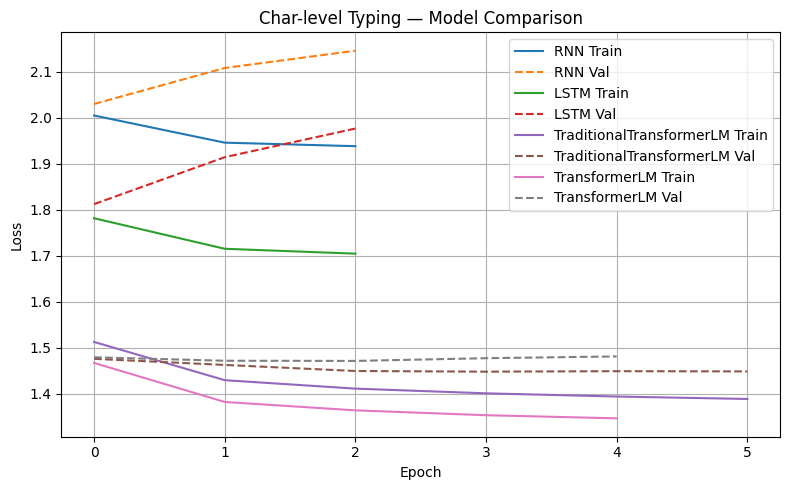

In [ ]:
plt.figure(figsize=(8, 5))
for name, metrics in results.items():
    plt.plot(metrics["train_losses"], label=f"{name} Train")
    plt.plot(metrics["val_losses"], label=f"{name} Val", linestyle="--")
plt.title("Char-level Typing — Model Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:

print("\n📊 Final Comparison Summary:")
print(f"{'Model':<15} {'Loss':<10} {'Acc (%)':<10} {'PPL':<10}")
print("-" * 45)
for name, m in results.items():
    print(f"{name:<15} {m['final_loss']:<10.4f} {m['final_acc']*100:<10.2f} {m['final_ppl']:<10.2f}")
print("\n✅ ===== Experiment Complete =====\n")


📊 Final Comparison Summary:
Model           Loss       Acc (%)    PPL       
---------------------------------------------
RNN             2.1452     44.14      8.54      
LSTM            1.9761     50.59      7.21      
TraditionalTransformerLM 1.4484     57.70      4.26      
TransformerLM   1.4810     57.73      4.40      

✅ ===== Experiment Complete =====



In [ ]:
!ls outputs

checkpoints  experiment_config_20251016_021325.json


In [ ]:
!ls outputs/checkpoints/

lstm_char_typing.pt  traditionaltransformerlm_char_typing.pt
rnn_char_typing.pt   transformerlm_char_typing.pt


In [ ]:
cfg

{'model_type': 'RNN', 'dim': 64, 'layers': 1, 'lr': 0.001, 'epochs': 6}

In [ ]:
cfg_now = model_configs["TransformerLM"]

In [ ]:
cfg_now

{'model_type': 'TransformerLM',
 'dim': 128,
 'layers': 2,
 'heads': 2,
 'lr': 0.0008,
 'epochs': 6}

In [ ]:
data.vocab_size

69

In [ ]:
from DeepDataMiningLearning.llm.transformer import ModelConfig, TransformerLM
device = "cuda" if torch.cuda.is_available() else "cpu"

# ------------------------------------------------------------
# Load checkpoint (contains both weights and cfg)
# ------------------------------------------------------------
ckpt_path = "outputs/checkpoints/transformerlm_char_typing.pt"
ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
state_dict = ckpt["model"]
cfg_dict = ckpt["cfg"]

print("✅ Config loaded from checkpoint:", cfg_dict)

✅ Config loaded from checkpoint: ModelConfig(vocab_size=69, dim=128, n_layers=2, n_heads=2, mlp_mult=4.0, dropout=0.1, max_seq_len=64, rope=True, tie_weights=True)


In [ ]:
cfg_dict

ModelConfig(vocab_size=69, dim=128, n_layers=2, n_heads=2, mlp_mult=4.0, dropout=0.1, max_seq_len=64, rope=True, tie_weights=True)

In [ ]:
# ------------------------------------------------------------
# Initialize the model using the saved configuration
# ------------------------------------------------------------
model = TransformerLM(cfg_dict)
model.load_state_dict(state_dict)
model.to(device).eval()

print("✅ Model rebuilt successfully with vocab_size =", cfg_dict.vocab_size)

✅ Model rebuilt successfully with vocab_size = 69


In [ ]:
# ------------------------------------------------------------
# Load tokenizer (char-level tokenizer from training)
# ------------------------------------------------------------
tokenizer = data.tok


In [ ]:

# ------------------------------------------------------------
# Perform inference
# ------------------------------------------------------------
prompt = "The cat"
input_ids = tokenizer.encode(prompt)
print(f"\n📝 Prompt: '{prompt}' ({len(input_ids)} tokens)")

seq_len = 64
max_new_tokens = 50

for _ in range(max_new_tokens):
    x = torch.tensor(input_ids[-seq_len:], dtype=torch.long, device=device)[None, :]
    with torch.no_grad():
        logits = model(x)[0, -1, :]
    next_token = torch.argmax(logits, dim=-1).item()
    input_ids.append(next_token)

output_text = tokenizer.decode(input_ids)
print("\n🧩 Generated text:\n", output_text)


📝 Prompt: 'The cat' (7 tokens)

🧩 Generated text:
 he catter or strike stand as, to strip a stringe.-to str


In [ ]:
def inference_from_checkpoint(
    ckpt_path,
    tokenizer,
    prompt="The cat",
    device="cuda" if torch.cuda.is_available() else "cpu",
    seq_len=64,
    max_new_tokens=50,
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    num_samples=3,
):
    """
    Unified inference function for TransformerLM checkpoints.

    Features:
      ✅ Loads both model weights and cfg directly from checkpoint
      ✅ Builds TransformerLM automatically
      ✅ Uses tokenizer provided by caller
      ✅ Supports greedy, temperature, top-k, top-p sampling
      ✅ Prints multiple generated samples

    Args:
        ckpt_path (str): Path to .pt checkpoint (contains "model" and "cfg").
        tokenizer: Tokenizer object with encode()/decode().
        prompt (str): Input text prompt for generation.
        device (str): "cuda" or "cpu".
        seq_len (int): Context window size.
        max_new_tokens (int): Number of tokens to generate.
        temperature (float): Sampling temperature.
        top_k (int): Use top-K sampling if > 0.
        top_p (float): Use nucleus (top-p) sampling if < 1.0.
        num_samples (int): Number of completions to generate.
    """

    # ------------------------------------------------------------
    # 1️⃣ Load checkpoint and configuration
    # ------------------------------------------------------------
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"❌ Checkpoint not found: {ckpt_path}")

    ckpt = torch.load(ckpt_path, map_location=device, weights_only=False)
    state_dict = ckpt["model"]
    cfg = ckpt["cfg"]

    print("✅ Config loaded from checkpoint:", cfg)
    model = TransformerLM(cfg)
    model.load_state_dict(state_dict)
    model.to(device).eval()
    print(f"✅ Model rebuilt successfully with vocab_size = {cfg.vocab_size}")

    # ------------------------------------------------------------
    # 2️⃣ Sampling helper
    # ------------------------------------------------------------
    def sample_next_token(logits):
        """Sample next token index from logits using chosen method."""
        logits = logits / max(temperature, 1e-6)
        probs = torch.softmax(logits, dim=-1)

        # Top-K sampling
        if top_k > 0:
            vals, idx = torch.topk(probs, top_k)
            probs = torch.zeros_like(probs).scatter_(0, idx, vals)
            probs = probs / probs.sum()

        # Top-P (nucleus) sampling
        if top_p < 1.0:
            sorted_probs, sorted_idx = torch.sort(probs, descending=True)
            cumulative = torch.cumsum(sorted_probs, dim=-1)
            cutoff = cumulative > top_p
            if torch.any(cutoff):
                cutoff_idx = torch.nonzero(cutoff)[0].item()
                keep_idx = sorted_idx[: cutoff_idx + 1]
                probs = torch.zeros_like(probs).scatter_(0, keep_idx, probs[keep_idx])
                probs = probs / probs.sum()

        next_id = torch.multinomial(probs, 1).item()
        return next_id

    # ------------------------------------------------------------
    # 3️⃣ Encode prompt and generate samples
    # ------------------------------------------------------------
    prompt_ids = tokenizer.encode(prompt)
    print(f"\n📝 Prompt: '{prompt}' ({len(prompt_ids)} tokens)\n")

    for i in range(num_samples):
        ids = prompt_ids.copy()
        print(f"🎯 Generating Sample {i + 1}/{num_samples}...")
        for _ in range(max_new_tokens):
            x = torch.tensor(ids[-seq_len:], dtype=torch.long, device=device)[None, :]
            with torch.no_grad():
                logits = model(x)[0, -1, :]
            next_id = sample_next_token(logits.cpu())
            ids.append(next_id)
        text = tokenizer.decode(ids)
        print(f"\n🧩 Sample {i+1} Output:\n{text}\n" + "-" * 60)

    print("✨ Inference complete.\n")

In [ ]:
inference_from_checkpoint(
    ckpt_path="outputs/checkpoints/transformerlm_char_typing.pt",
    tokenizer=tokenizer,
    prompt="a small tree of the",
    seq_len=64,
    max_new_tokens=60,
    temperature=0.8,
    top_k=40,
    top_p=0.9,
    num_samples=3,
)

✅ Config loaded from checkpoint: ModelConfig(vocab_size=69, dim=128, n_layers=2, n_heads=2, mlp_mult=4.0, dropout=0.1, max_seq_len=64, rope=True, tie_weights=True)
✅ Model rebuilt successfully with vocab_size = 69

📝 Prompt: 'a small tree of the' (20 tokens)

🎯 Generating Sample 1/3...

🧩 Sample 1 Output:
a small tree of theel as a stress, to any struction of a strike mean appendent.
------------------------------------------------------------
🎯 Generating Sample 2/3...

🧩 Sample 2 Output:
a small tree of the rest or large freed.-the leavenly and opolygonanism or marr
------------------------------------------------------------
🎯 Generating Sample 3/3...

🧩 Sample 3 Output:
a small tree of theing als, a place, or leather.-the filament of monistration o
------------------------------------------------------------
✨ Inference complete.



In [ ]:
!zip -r outputs.zip outputs

  adding: outputs/ (stored 0%)
  adding: outputs/checkpoints/ (stored 0%)
  adding: outputs/checkpoints/rnn_char_typing.pt (deflated 10%)
  adding: outputs/checkpoints/transformerlm_char_typing.pt (deflated 7%)
  adding: outputs/checkpoints/traditionaltransformerlm_char_typing.pt (deflated 7%)
  adding: outputs/checkpoints/lstm_char_typing.pt (deflated 8%)
  adding: outputs/experiment_config_20251016_021325.json (deflated 73%)


The newer components (RMSNorm, SwiGLU, RoPE) are designed for:
	•	Large-scale, deep Transformers
	•	High-dimensional embeddings (512–4096)
	•	Long sequences (hundreds–thousands of tokens)

These do not suitable for a tiny Transformer (dim=128, seq_len=64, vocab≈100)

In [3]:
from DeepDataMiningLearning.llm.experiments import run_char_typing_experiment, run_qwen_finetune_experiment

In [4]:
run_char_typing_experiment()


🚀 ===== Character-Level Typing Experiment =====
📘 Building char-level typing dataset from 'npvinHnivqn/EnglishDictionary'...
📗 Building DataModule for task='lm' (tokenizer=char, seq_len=64)
📚 Loading Hugging Face dataset: 'npvinHnivqn/EnglishDictionary'
🧩 Detected configs: ['default']
✅ Using first available config: 'default'
📗 Using split: 'train'
🔤 Using text field(s): ['definition']
✅ Loaded 111,601 text entries from 'npvinHnivqn/EnglishDictionary' (config=default)
🧹 Cleaning raw text ...
✅ clean_texts: kept 124,088/124,090 lines (100.00% retained)
✅ Cleaned text length: 12,661,076 chars (124,088 lines kept)
🔤 Setting up tokenizer via TokenizerFactory: char
🔤 Building CharTokenizer ...
✅ CharTokenizer initialized | vocab_size=70 | pad_idx=0 | eos_idx=1 | unk_idx=2
✅ Tokenizer initialized | type=char | vocab_size=70 | pad_id=-100
🧩 Building LM dataset ...
🧩 Encoding text in chunks (chunk_size=50000) ...


Encoding: 100%|██████████| 3/3 [00:00<00:00,  4.62it/s]


✅ Encoded 12,661,077 tokens total
⚙️  Using sliding window stride=1
📏 Built 12,661,013 sequences of len=64
🧾 Sample types: type(sequences[0])=<class 'list'>
  Inner element type: <class 'int'>
✅ Dataset split: 11,394,911 train | 1,266,102 val sequences

🔍 ===== DATASET INSPECTION =====
🧩 Task type: lm
📦 Train batches: 178045 | Validation batches: 19783
🔡 Vocabulary size: 70

🧩 --- Inspecting train batch 1/4 ---
🔹 Batch type: tuple (len=3)
  • tensor[0]: shape=(64, 63), dtype=torch.int64
  • tensor[1]: shape=(64, 63), dtype=torch.int64
  • tensor[2]: shape=(64,), dtype=torch.int64
  • Avg length: 63.0 | Min: 63 | Max: 63
  • Pad ratio: 0.00%  (pad_id=-100)
  • Label unique tokens: 36
  • Label vocab coverage: 51.43% of vocab
  • Label pad ratio: 0.00%
  • Top 5 label IDs: [(np.int64(4), 627), (np.int64(44), 366), (np.int64(54), 292), (np.int64(59), 266), (np.int64(40), 254)]

🗣️ Decoded examples:
   1. r
a tambourine.-an old provencal dance of a lively character, c
      → target: 
a ta

Epoch 1/6: 100%|██████████| 178045/178045 [24:11<00:00, 122.65it/s, loss=1.4649, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 357.89it/s]


✅ Eval complete | loss=1.3714 | acc=57.33% | ppl=3.94

✅ Epoch 1 done | val_loss=1.3714 | acc=57.33% | ppl=3.94
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 2/6: 100%|██████████| 178045/178045 [23:08<00:00, 128.19it/s, loss=1.4114, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 358.24it/s]


✅ Eval complete | loss=1.3607 | acc=57.63% | ppl=3.90

✅ Epoch 2 done | val_loss=1.3607 | acc=57.63% | ppl=3.90
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 3/6: 100%|██████████| 178045/178045 [24:05<00:00, 123.14it/s, loss=1.4009, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 357.90it/s]


✅ Eval complete | loss=1.3533 | acc=57.91% | ppl=3.87

✅ Epoch 3 done | val_loss=1.3533 | acc=57.91% | ppl=3.87
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 4/6: 100%|██████████| 178045/178045 [24:20<00:00, 121.90it/s, loss=1.3953, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 358.12it/s]


✅ Eval complete | loss=1.3539 | acc=57.89% | ppl=3.87

✅ Epoch 4 done | val_loss=1.3539 | acc=57.89% | ppl=3.87
⚠️ No improvement for 1 epochs.


Epoch 5/6: 100%|██████████| 178045/178045 [23:54<00:00, 124.09it/s, loss=1.3916, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 358.12it/s]


✅ Eval complete | loss=1.3482 | acc=58.00% | ppl=3.85

✅ Epoch 5 done | val_loss=1.3482 | acc=58.00% | ppl=3.85
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt


Epoch 6/6: 100%|██████████| 178045/178045 [23:47<00:00, 124.70it/s, loss=1.3891, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 358.89it/s]


✅ Eval complete | loss=1.3469 | acc=58.07% | ppl=3.85

✅ Epoch 6 done | val_loss=1.3469 | acc=58.07% | ppl=3.85
💾 Saved best model → outputs/checkpoints/traditionaltransformerlm_char_typing.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 359.07it/s]


✅ Eval complete | loss=1.3469 | acc=58.07% | ppl=3.85

✅ TraditionalTransformerLM — loss=1.3469 | acc=58.07% | ppl=3.85


🧠 Training TransformerLM model...
🚀 Initializing modern TransformerLM (RMSNorm + RoPE + SwiGLU)
📅 Total training steps: 1068270
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6: 100%|██████████| 178045/178045 [23:50<00:00, 124.45it/s, loss=1.4265, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 354.70it/s]


✅ Eval complete | loss=1.3733 | acc=57.47% | ppl=3.95

✅ Epoch 1 done | val_loss=1.3733 | acc=57.47% | ppl=3.95
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 2/6: 100%|██████████| 178045/178045 [24:36<00:00, 120.58it/s, loss=1.3655, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 355.67it/s]


✅ Eval complete | loss=1.3601 | acc=57.88% | ppl=3.90

✅ Epoch 2 done | val_loss=1.3601 | acc=57.88% | ppl=3.90
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 3/6: 100%|██████████| 178045/178045 [24:56<00:00, 118.95it/s, loss=1.3545, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [01:15<00:00, 261.95it/s]


✅ Eval complete | loss=1.3558 | acc=57.96% | ppl=3.88

✅ Epoch 3 done | val_loss=1.3558 | acc=57.96% | ppl=3.88
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 4/6: 100%|██████████| 178045/178045 [25:18<00:00, 117.24it/s, loss=1.3485, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [01:15<00:00, 262.97it/s]


✅ Eval complete | loss=1.3516 | acc=58.17% | ppl=3.86

✅ Epoch 4 done | val_loss=1.3516 | acc=58.17% | ppl=3.86
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 5/6: 100%|██████████| 178045/178045 [25:51<00:00, 114.77it/s, loss=1.3444, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [01:15<00:00, 262.68it/s]


✅ Eval complete | loss=1.3485 | acc=58.21% | ppl=3.85

✅ Epoch 5 done | val_loss=1.3485 | acc=58.21% | ppl=3.85
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt


Epoch 6/6: 100%|██████████| 178045/178045 [25:57<00:00, 114.34it/s, loss=1.3415, lr=8.000000e-04]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [01:15<00:00, 263.23it/s]


✅ Eval complete | loss=1.3474 | acc=58.30% | ppl=3.85

✅ Epoch 6 done | val_loss=1.3474 | acc=58.30% | ppl=3.85
💾 Saved best model → outputs/checkpoints/transformerlm_char_typing.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [01:15<00:00, 263.34it/s]


✅ Eval complete | loss=1.3475 | acc=58.29% | ppl=3.85

✅ TransformerLM — loss=1.3475 | acc=58.29% | ppl=3.85


🧠 Training RNN model...
🧠 Initializing traditional RNN Language Model...
📅 Total training steps: 1068270
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6: 100%|██████████| 178045/178045 [16:14<00:00, 182.78it/s, loss=1.9634, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 341.80it/s]


✅ Eval complete | loss=1.8406 | acc=44.39% | ppl=6.30

✅ Epoch 1 done | val_loss=1.8406 | acc=44.39% | ppl=6.30
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 2/6: 100%|██████████| 178045/178045 [15:54<00:00, 186.61it/s, loss=1.9348, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 341.62it/s]


✅ Eval complete | loss=1.8348 | acc=44.64% | ppl=6.26

✅ Epoch 2 done | val_loss=1.8348 | acc=44.64% | ppl=6.26
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 3/6: 100%|██████████| 178045/178045 [16:13<00:00, 182.98it/s, loss=1.9314, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 341.57it/s]


✅ Eval complete | loss=1.8324 | acc=44.74% | ppl=6.25

✅ Epoch 3 done | val_loss=1.8324 | acc=44.74% | ppl=6.25
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 4/6: 100%|██████████| 178045/178045 [16:28<00:00, 180.15it/s, loss=1.9294, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:58<00:00, 341.08it/s]


✅ Eval complete | loss=1.8310 | acc=44.93% | ppl=6.24

✅ Epoch 4 done | val_loss=1.8310 | acc=44.93% | ppl=6.24
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 5/6: 100%|██████████| 178045/178045 [15:48<00:00, 187.73it/s, loss=1.9277, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 341.09it/s]


✅ Eval complete | loss=1.8273 | acc=44.91% | ppl=6.22

✅ Epoch 5 done | val_loss=1.8273 | acc=44.91% | ppl=6.22
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt


Epoch 6/6: 100%|██████████| 178045/178045 [16:15<00:00, 182.45it/s, loss=1.9256, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 341.37it/s]


✅ Eval complete | loss=1.8246 | acc=44.91% | ppl=6.20

✅ Epoch 6 done | val_loss=1.8246 | acc=44.91% | ppl=6.20
💾 Saved best model → outputs/checkpoints/rnn_char_typing.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 341.16it/s]


✅ Eval complete | loss=1.8246 | acc=44.91% | ppl=6.20

✅ RNN — loss=1.8246 | acc=44.91% | ppl=6.20


🧠 Training LSTM model...
🧠 Initializing LSTM Language Model...
📅 Total training steps: 1068270
📉 Using ReduceLROnPlateau scheduler (adaptive LR on validation loss)

🔧 Using AMP: False | dtype: torch.bfloat16 | scaler: False

🚀 Training for 6 epochs on cuda (mode=teacher-forced)


Epoch 1/6: 100%|██████████| 178045/178045 [17:00<00:00, 174.49it/s, loss=1.7377, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:58<00:00, 338.54it/s]


✅ Eval complete | loss=1.6133 | acc=50.91% | ppl=5.02

✅ Epoch 1 done | val_loss=1.6133 | acc=50.91% | ppl=5.02
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 2/6: 100%|██████████| 178045/178045 [16:48<00:00, 176.49it/s, loss=1.7032, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:55<00:00, 359.62it/s]


✅ Eval complete | loss=1.6043 | acc=51.14% | ppl=4.97

✅ Epoch 2 done | val_loss=1.6043 | acc=51.14% | ppl=4.97
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 3/6: 100%|██████████| 178045/178045 [16:03<00:00, 184.75it/s, loss=1.6970, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:54<00:00, 362.97it/s]


✅ Eval complete | loss=1.5998 | acc=51.35% | ppl=4.95

✅ Epoch 3 done | val_loss=1.5998 | acc=51.35% | ppl=4.95
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 4/6: 100%|██████████| 178045/178045 [16:01<00:00, 185.12it/s, loss=1.6940, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:54<00:00, 360.82it/s]


✅ Eval complete | loss=1.5985 | acc=51.24% | ppl=4.95

✅ Epoch 4 done | val_loss=1.5985 | acc=51.24% | ppl=4.95
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 5/6: 100%|██████████| 178045/178045 [16:18<00:00, 181.89it/s, loss=1.6923, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 342.00it/s]


✅ Eval complete | loss=1.5966 | acc=51.30% | ppl=4.94

✅ Epoch 5 done | val_loss=1.5966 | acc=51.30% | ppl=4.94
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt


Epoch 6/6: 100%|██████████| 178045/178045 [16:45<00:00, 177.09it/s, loss=1.6910, lr=1.000000e-03]



🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 343.10it/s]


✅ Eval complete | loss=1.5953 | acc=51.41% | ppl=4.93

✅ Epoch 6 done | val_loss=1.5953 | acc=51.41% | ppl=4.93
💾 Saved best model → outputs/checkpoints/lstm_char_typing.pt

✅ Training complete.

🔍 Evaluating split = valid ...


Eval valid: 100%|██████████| 19783/19783 [00:57<00:00, 342.67it/s]


✅ Eval complete | loss=1.5953 | acc=51.41% | ppl=4.93

✅ LSTM — loss=1.5953 | acc=51.41% | ppl=4.93



AttributeError: module 'datetime' has no attribute 'now'

In [ ]:
from DeepDataMiningLearning.llm.experiments import run_tokenizer_comparison_experiment
run_tokenizer_comparison_experiment(
    hf_name="npvinHnivqn/EnglishDictionary",
    seq_len=64,
    batch_size=128, #32,
    epochs=4,  # Reduced for faster testing
    output_dir="outputs/tokenizer_comparison"
)

In [2]:
!pip install jieba

  Using cached jieba-0.42.1.tar.gz (19.2 MB)
  Preparing metadata (setup.py) ... done
  Created wheel for jieba: filename=jieba-0.42.1-py3-none-any.whl size=19314508 sha256=dbb1c7f0cb672446a2bff77009e1b169708d07f0367745e07c09d26cfacce6ad
  Stored in directory: /fs/atipa/home/010796032/.cache/pip/wheels/08/a1/a3/5c8ac52cc2f5782ffffc34c95c57c8e5ecb3063dc69541ee7c
Successfully built jieba


In [ ]:
from DeepDataMiningLearning.llm.experiments import run_qwen_finetune_experiment
run_qwen_finetune_experiment()

🚀 Starting Qwen2.5-3B fine-tuning experiment...

📘 Building predictive typing dataset from 'OpenAssistant/oasst1'...
📗 Building DataModule for task='lm' (tokenizer=hf:Qwen/Qwen2.5-3B, seq_len=256)
📚 Loading Hugging Face dataset: 'OpenAssistant/oasst1'
🧩 Detected configs: ['default']
✅ Using first available config: 'default'
📗 Using split: 'train'
🔤 Using text field(s): ['text']
✅ Loaded 84,437 text entries from 'OpenAssistant/oasst1' (config=default)
🧹 Cleaning raw text ...
✅ clean_texts: kept 332,479/345,782 lines (96.15% retained)
✅ Cleaned text length: 37,859,735 chars (332,479 lines kept)
🔤 Setting up tokenizer via TokenizerFactory: hf:Qwen/Qwen2.5-3B
🤗 Loading Hugging Face tokenizer: Qwen/Qwen2.5-3B
🌐 Loading pretrained tokenizer from Hugging Face Hub: Qwen/Qwen2.5-3B
⚙️  Detected Byte-Level BPE family → verifying pre-tokenizer/decoder ...
✅ HFTokenizerWrapper initialized from 'Qwen/Qwen2.5-3B' | vocab_size=151643 | pad_id=151643
✅ Tokenizer initialized | type=hf:Qwen/Qwen2.5-3B |

Tokenizing: 100%|██████████| 333/333 [00:08<00:00, 37.97it/s]


✅ Encoded 9,331,777 tokens total (avg tokens/line ≈ 28)
⚙️  Using sliding window stride=64


`torch_dtype` is deprecated! Use `dtype` instead!


📏 Built 145,806 sequences of len=256
🧾 Sample types: type(sequences[0])=<class 'list'>
  Inner element type: <class 'int'>
✅ Dataset split: 131,225 train | 14,581 val sequences

🔍 ===== DATASET INSPECTION =====
🧩 Task type: lm
📦 Train batches: 65612 | Validation batches: 7291
🔡 Vocabulary size: 151,643

🧩 --- Inspecting train batch 1/1 ---
🔹 Batch type: tuple (len=3)
  • tensor[0]: shape=(2, 255), dtype=torch.int64
  • tensor[1]: shape=(2, 255), dtype=torch.int64
  • tensor[2]: shape=(2,), dtype=torch.int64
  • Avg length: 255.0 | Min: 255 | Max: 255
  • Pad ratio: 0.00%  (pad_id=151643)
  • Label unique tokens: 288
  • Label vocab coverage: 0.19% of vocab
  • Label pad ratio: 0.00%
  • Top 5 label IDs: [(np.int64(284), 16), (np.int64(11), 15), (np.int64(25), 14), (np.int64(2638), 12), (np.int64(13), 11)]

🗣️ Decoded examples:
   1. _file, output_path):with open(csv_file, "r") as file:reader = csv.reader(file)header = next(reader) # skip the header rowfor row in reader:name, url, ratin